In [1]:
# ========================================
# CELL 1: Load & Normalize Data
# ========================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.max_columns", 100)

# Set data directory - UPDATED FOR REPO STRUCTURE
# Option 1: Relative path (recommended - works anywhere)
# Notebook is in: exploratory_analysis/osei/
# Data is in: resources/raw_data/
# So go up 2 levels (../../) then into resources/raw_data/
RELATIVE_DIR = os.path.join(os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd(), '..', '..', 'resources', 'raw_data')

# Option 2: Absolute path (backup)
ABSOLUTE_DIR = r"C:\Users\oseic\Downloads\Data_Edge_Internal_Data\data-edge-dashboard\resources\raw_data"

# Try relative first, fall back to absolute
if os.path.exists(RELATIVE_DIR):
    DATA_DIR = RELATIVE_DIR
elif os.path.exists(ABSOLUTE_DIR):
    DATA_DIR = ABSOLUTE_DIR
else:
    # If neither exists, try simple relative path
    DATA_DIR = os.path.join('..', '..', 'resources', 'raw_data')

print("Using DATA_DIR:", DATA_DIR)
print("Directory exists:", os.path.exists(DATA_DIR))

# Verify the data files exist
required_files = [
    "dim__projects__anonymized.csv",
    "dim__notion_roles__anonymized.csv",
    "fct__time_entries.csv"
]

print("\nChecking for data files:")
for filename in required_files:
    filepath = os.path.join(DATA_DIR, filename)
    exists = os.path.exists(filepath)
    print(f"  {'✓' if exists else '✗'} {filename}")

# Load datasets
projects = pd.read_csv(os.path.join(DATA_DIR, "dim__projects__anonymized.csv"))
roles = pd.read_csv(os.path.join(DATA_DIR, "dim__notion_roles__anonymized.csv"))
time = pd.read_csv(os.path.join(DATA_DIR, "fct__time_entries.csv"))

print(f"\nLoaded data:")
print(f"  Projects: {projects.shape}")
print(f"  Roles: {roles.shape}")
print(f"  Time entries: {time.shape}")

# Parse dates
time["dt"] = pd.to_datetime(time["dt"], errors="coerce")
time["month"] = time["dt"].dt.to_period("M").dt.to_timestamp()
time["year"] = time["dt"].dt.year
time["week"] = time["dt"].dt.to_period("W").dt.to_timestamp()

# Normalize join keys (case-insensitive, trimmed)
projects["client_anon_key"] = projects["client_anon"].astype(str).str.strip().str.lower()
roles["client_anon_key"] = roles["name_anon"].astype(str).str.strip().str.lower()

Using DATA_DIR: c:\Users\oseic\Downloads\Data_Edge_Internal_Data\data-edge-dashboard\exploratory_analysis\osei\..\..\resources\raw_data
Directory exists: True

Checking for data files:
  ✓ dim__projects__anonymized.csv
  ✓ dim__notion_roles__anonymized.csv
  ✓ fct__time_entries.csv

Loaded data:
  Projects: (91, 7)
  Roles: (101, 8)
  Time entries: (9808, 7)


In [2]:
# ========================================
# CELL 2: Join Time Entries → Projects
# ========================================

# Join time entries to projects
fact = time.merge(
    projects[["project_id", "client_id", "client_anon", "client_anon_key", "project_anon", "project_duration_hours"]],
    on="project_id",
    how="left"
)

# Check match rate
match_rate = fact["client_id"].notna().mean()
print(f"Time entries matched to projects: {match_rate:.1%} ({fact['client_id'].notna().sum():,}/{len(fact):,})")

# Recompute clean billable hours (use explicit billable flag)
fact["billable_hours_clean"] = np.where(
    fact["billable"] == True,
    fact["hours"].fillna(0),
    0.0
)

print(f"\n✓ Fact table after project join: {fact.shape}")
display(fact.head(3))

KeyError: "['project_duration_hours'] not in index"

In [ ]:
# ========================================
# CELL 3: Join to Roles via client_anon
# ========================================

print("Before role join:", fact.shape)

# Join to roles on client_anon_key (one time entry can match multiple roles per client)
fact = fact.merge(
    roles[["client_anon_key", "industry_name", "role_category_name", "hourly_rate", "seniority", "billing_type"]],
    on="client_anon_key",
    how="left"
)

print(f"After role join: {fact.shape}")
print(f"Row explosion: {len(fact) / len(time):.2f}x (each time entry × roles per client)")

# Check coverage
role_match_rate = fact["role_category_name"].notna().mean()
print(f"\nTime entries matched to roles: {role_match_rate:.1%}")

print("\n✓ Roles joined - now at time-entry-role grain")
display(fact.head(5))

Before role join: (9808, 16)
After role join: (24784, 21)
Row explosion: 2.53x (each time entry × roles per client)

Time entries matched to roles: 64.5%

✓ Roles joined - now at time-entry-role grain


,dt,time_entry_id,project_id,user_id,billable,hours,billable_hours,month,year,week,client_id,client_anon,client_anon_key,project_anon,project_duration_hours,billable_hours_clean,industry_name,role_category_name,hourly_rate,seniority,billing_type
0,2025-11-28,67c592453f4d6b42ba2ee7bb,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2025-11-27,67c592453f4d6b42ba2ee7ba,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2025-11-26,67c592453f4d6b42ba2ee7b9,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2025-11-25,67c592453f4d6b42ba2ee7b8,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2025-11-24,67c592453f4d6b42ba2ee7b7,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ========================================
# CELL 4: Enrich & Calculate (CORRECTED)
# ========================================

# Classify industries (prioritize role data, fallback to keywords)
internal_keywords = ["interntid", "semester", "föräldraledighet", "sjuk", "obetald", 
                     "competence", "training", "admin"]

def classify_industry(row):
    # Priority 1: Use industry from roles
    if pd.notna(row.get("industry_name")):
        return row["industry_name"]
    
    # Priority 2: Keyword-based classification
    proj = str(row.get("project_anon", "")).lower()
    if any(kw in proj for kw in internal_keywords):
        return "Internal"
    
    return "Unclassified"

fact["industry_clean"] = fact.apply(classify_industry, axis=1)

# Flag internal vs client-facing work (THIS IS KEY!)
fact["is_internal"] = fact["industry_clean"] == "Internal"
fact["is_client_facing"] = ~fact["is_internal"]  # Anything NOT internal is client-facing

# Separate hour types
fact["client_facing_hours"] = np.where(fact["is_client_facing"], fact["hours"], 0)
fact["internal_hours"] = np.where(fact["is_internal"], fact["hours"], 0)

# Billable hours (for revenue calculations)
fact["billable_hours_final"] = fact["billable_hours_clean"]

# Calculate projected billings (billable hours × hourly rate)
fact["projected_billings"] = fact["billable_hours_final"] * fact["hourly_rate"].fillna(0)

# Add useful flags
fact["has_role_data"] = fact["role_category_name"].notna()
fact["has_industry_data"] = fact["industry_name"].notna()

print("✓ Derived fields added")
print(f"\nHours breakdown:")
print(f"  Total hours: {fact['hours'].sum():,.0f}")
print(f"  Client-facing hours: {fact['client_facing_hours'].sum():,.0f} ({fact['client_facing_hours'].sum()/fact['hours'].sum():.1%})")
print(f"  Internal hours: {fact['internal_hours'].sum():,.0f} ({fact['internal_hours'].sum()/fact['hours'].sum():.1%})")
print(f"  Billable hours: {fact['billable_hours_final'].sum():,.0f}")

print(f"\nIndustry distribution:")
print(fact["industry_clean"].value_counts())

display(fact.head(5))

✓ Derived fields added

Hours breakdown:
  Total hours: 162,207
  Client-facing hours: 134,684 (83.0%)
  Internal hours: 27,523 (17.0%)
  Billable hours: 133,890

Industry distribution:
industry_clean
Financial Services              10132
Internal                         4146
Manufacturing                    3566
Energy and Utilities             2256
Unclassified                     1217
Tech                             1027
Retail and Consumer Goods        1018
Public sector                     964
Construction and Real Estate      458
Name: count, dtype: int64


,dt,time_entry_id,project_id,user_id,billable,hours,billable_hours,month,year,week,client_id,client_anon,client_anon_key,project_anon,project_duration_hours,billable_hours_clean,industry_name,role_category_name,hourly_rate,seniority,billing_type,industry_clean,is_internal,projected_billings,has_role_data,has_industry_data,is_client_facing,client_facing_hours,internal_hours,billable_hours_final
0,2025-11-28,67c592453f4d6b42ba2ee7bb,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN,Internal,True,0.0,False,False,False,0.0,8.0,0.0
1,2025-11-27,67c592453f4d6b42ba2ee7ba,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN,Internal,True,0.0,False,False,False,0.0,8.0,0.0
2,2025-11-26,67c592453f4d6b42ba2ee7b9,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN,Internal,True,0.0,False,False,False,0.0,8.0,0.0
3,2025-11-25,67c592453f4d6b42ba2ee7b8,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN,Internal,True,0.0,False,False,False,0.0,8.0,0.0
4,2025-11-24,67c592453f4d6b42ba2ee7b7,60106d6e9ab6ce7c1dacbc9c,64e5f63d97f5910c716406b8,False,8.0,NaN,2025-11-01,2025,2025-11-24,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Föräldraledighet,7156.0,0.0,NaN,NaN,NaN,NaN,NaN,Internal,True,0.0,False,False,False,0.0,8.0,0.0


In [ ]:
# ========================================
# CELL 5: Validate Fact Table
# ========================================

print("=" * 60)
print("FACT TABLE SUMMARY")
print("=" * 60)

print(f"\n📊 Structure:")
print(f"  Total rows: {len(fact):,}")
print(f"  Grain: time_entry_id × role (one time entry can have multiple role rows)")
print(f"  Columns: {len(fact.columns)}")
print(f"  Memory: {fact.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\n📅 Time Range:")
print(f"  Start: {fact['dt'].min()}")
print(f"  End: {fact['dt'].max()}")
print(f"  Months: {fact['month'].nunique()}")

print(f"\n🏢 Coverage:")
print(f"  Unique projects: {fact['project_id'].nunique()}")
print(f"  Unique clients: {fact['client_id'].nunique()}")
print(f"  Unique time entries: {fact['time_entry_id'].nunique()}")
print(f"  Unique users: {fact['user_id'].nunique()}")

print(f"\n⏱️ Hours Summary:")
print(f"  Total hours: {fact['hours'].sum():,.1f}")
print(f"  Billable hours: {fact['billable_hours_clean'].sum():,.1f}")
print(f"  Utilization: {fact['billable_hours_clean'].sum() / fact['hours'].sum():.1%}")

print(f"\n💰 Financial (with role data):")
with_rates = fact[fact['hourly_rate'].notna()]
print(f"  Projected billings: ${with_rates['projected_billings'].sum():,.0f}")
print(f"  Avg hourly rate: ${with_rates['hourly_rate'].mean():.0f}")

print(f"\n🏭 Industry Mix (top 5):")
print(fact.groupby("industry_clean")["hours"].sum().sort_values(ascending=False).head())

print(f"\n👔 Role Mix (top 5):")
print(fact.groupby("role_category_name")["hours"].sum().sort_values(ascending=False).head())

print(f"\n✅ Fact table ready for analysis!")
print(f"\nKey columns: {list(fact.columns)}")

# Sample rows
print("\n📋 Sample rows:")
display(fact.sample(min(10, len(fact))))

FACT TABLE SUMMARY

📊 Structure:
  Total rows: 24,784
  Grain: time_entry_id × role (one time entry can have multiple role rows)
  Columns: 30
  Memory: 21.1 MB

📅 Time Range:
  Start: 2020-08-03 00:00:00
  End: 2025-11-28 00:00:00
  Months: 64

🏢 Coverage:
  Unique projects: 65
  Unique clients: 38
  Unique time entries: 9808
  Unique users: 11

⏱️ Hours Summary:
  Total hours: 162,207.4
  Billable hours: 133,890.1
  Utilization: 82.5%

💰 Financial (with role data):
  Projected billings: $159,679,309
  Avg hourly rate: $1304

🏭 Industry Mix (top 5):
industry_clean
Financial Services      71776.500000
Internal                27523.333333
Manufacturing           18460.000000
Energy and Utilities    16430.000000
Unclassified             8818.566667
Name: hours, dtype: float64

👔 Role Mix (top 5):
role_category_name
Business Developer    35807.00
Data Engineer         18373.25
Data Scientist        17964.00
Data Analyst          14014.75
Data Architect        12507.00
Name: hours, dtype: 

,dt,time_entry_id,project_id,user_id,billable,hours,billable_hours,month,year,week,client_id,client_anon,client_anon_key,project_anon,project_duration_hours,billable_hours_clean,industry_name,role_category_name,hourly_rate,seniority,billing_type,industry_clean,is_internal,projected_billings,has_role_data,has_industry_data,is_client_facing,client_facing_hours,internal_hours,billable_hours_final
3638,2024-09-06,66e15ec8d2ef02363c5e6643,65eecc5033c90b16ead59691,64f5e9f270d77d3906fdbcf0,True,8.0,8.0,2024-09-01,2024,2024-09-02,65eecc3f36768531547fc52e,Joseph and Sons,joseph and sons,Nguyen-Torres,2582.0,8.0,Energy and Utilities,NaN,950.0,K2,Billing to Altero,Energy and Utilities,False,7600.0,False,True,True,8.0,0.0,8.0
21209,2022-02-15,621def34ba35e65bc33ee4a2,619e81ffb55cac13305c0358,5f7c718cf3fda011462c67c1,True,8.0,8.0,2022-02-01,2022,2022-02-14,613b393eac2a7406faeb54f1,Ortega Group,ortega group,Infra BI implementation - Implementation,1705.0,8.0,Manufacturing,NaN,1278.0,K2,NaN,Manufacturing,False,10224.0,False,True,True,8.0,0.0,8.0
18289,2022-09-09,633563d7e4da3051a5436fb5,626a5a6334fd3c736767565b,61e06b0375015b508b28241b,True,5.6,5.6,2022-09-01,2022,2022-09-05,6038e369b5d4135b129bb832,Sullivan PLC,sullivan plc,LF Analys / Datadriven affärsutveckling,4667.0,5.6,Financial Services,Data Scientist,1050.0,K2,Self-billing(ework),Financial Services,False,5880.0,True,True,True,5.6,0.0,5.6
15376,2023-02-22,63ff10246c533d00ff840cda,63ff0dff6c533d00ff83b9b0,5f68ec6a633ecf60f5e863ce,True,6.0,6.0,2023-02-01,2023,2023-02-20,63e664f7ea5a6117297c5c95,Price and Sons,price and sons,Advisor,388.0,6.0,Tech,Business Developer,1000.0,NaN,Direct billing,Tech,False,6000.0,True,True,True,6.0,0.0,6.0
4101,2024-07-31,66ab56ac433b4b794ecf0b57,5f437f189decb91192e37bc0,5f68ec6a633ecf60f5e863ce,False,8.0,NaN,2024-07-01,2024,2024-07-29,5f437b54d13ed94468add358,"Taylor, Simmons and Anderson","taylor, simmons and anderson",Semester,10321.0,0.0,NaN,NaN,NaN,NaN,NaN,Internal,True,0.0,False,False,False,0.0,8.0,0.0
20342,2022-04-12,6266dc6bf7a4597cbcb40c73,615df4cc939aa5668fb2890b,5f437ae67d26442bf5452ecd,True,7.0,7.0,2022-04-01,2022,2022-04-11,615df4c8939aa5668fb288ec,"Gamble, Summers and Bailey","gamble, summers and bailey",Chef data och analys,1213.0,7.0,Energy and Utilities,Business Developer,1300.0,K3,NaN,Energy and Utilities,False,9100.0,True,True,True,7.0,0.0,7.0
21430,2022-02-02,621d2540e475a260c9f84743,619e81ffb55cac13305c0358,5f437ae67d26442bf5452ecd,True,1.0,1.0,2022-02-01,2022,2022-01-31,613b393eac2a7406faeb54f1,Ortega Group,ortega group,Infra BI implementation - Implementation,1705.0,1.0,Manufacturing,NaN,1510.0,K2,Direct billing,Manufacturing,False,1510.0,False,True,True,1.0,0.0,1.0
19869,2022-05-09,627b71a1cc56ee15435cb220,619e81ffb55cac13305c0358,5f437ae67d26442bf5452ecd,True,1.0,1.0,2022-05-01,2022,2022-05-09,613b393eac2a7406faeb54f1,Ortega Group,ortega group,Infra BI implementation - Implementation,1705.0,1.0,Manufacturing,NaN,1200.0,NaN,NaN,Manufacturing,False,1200.0,False,True,True,1.0,0.0,1.0
19570,2022-05-25,6295c5fc05d9b26232356e55,615df4cc939aa5668fb2890b,5f437ae67d26442bf5452ecd,True,8.0,8.0,2022-05-01,2022,2022-05-23,615df4c8939aa5668fb288ec,"Gamble, Summers and Bailey","gamble, summers and bailey",Chef data och analys,1213.0,8.0,Energy and Utilities,Analytics Engineer,1200.0,NaN,NaN,Energy and Utilities,False,9600.0,True,True,True,8.0,0.0,8.0
10931,2023-09-29,65159274f7afc909ac5b1de1,626a5a6334fd3c736767565b,61e06b0375015b508b28241b,True,8.0,8.0,2023-09-01,2023,2023-09-25,6038e369b5d4135b129bb832,Sullivan PLC,sullivan plc,LF Analys / Datadriven affärsutveckling,4667.0,8.0,Financial Services,Business Developer,1450.0,NaN,Self-billing(ework),Financial Services,False,11600.0,True,True,True,8.0,0.0,8.0


,hours,billable_hours_clean,project_duration_hours,projected_billings
project_id,,,,
5f437b18d13ed94468add25e,3027.000000,3027.0,3027.0,0.0
5f437b557d26442bf54530ac,13461.133333,0.0,NaN,0.0
5f437f189decb91192e37bc0,6679.000000,0.0,10321.0,0.0
5f60a92df2bfed445099122e,192.000000,0.0,232.0,0.0
5f68f9ef5d3b7b2b1d6318e1,1313.000000,1313.0,1313.0,1706900.0
...,...,...,...,...
6715f9d290254d10ca81e784,994.000000,994.0,994.0,1018850.0
671fe491605d557fc53c80f3,924.000000,924.0,924.0,997920.0
677fb4341c567d719ff4f8bd,39.000000,39.0,39.0,58500.0


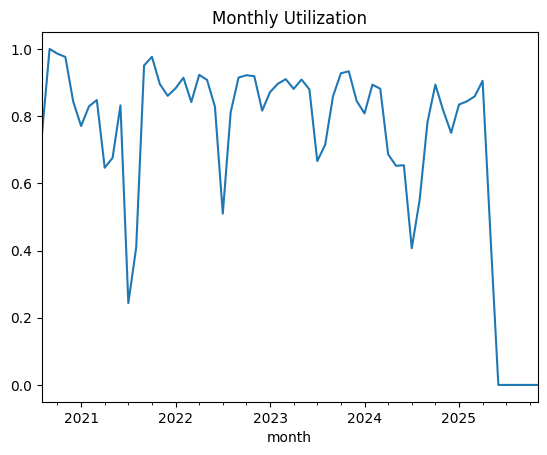

In [ ]:
# Monthly utilization trend
monthly_util = fact.groupby(['month', 'is_internal'])['hours'].sum().unstack(fill_value=0)
monthly_util['utilization'] = monthly_util[False] / (monthly_util[False] + monthly_util[True])
monthly_util['utilization'].plot(title="Monthly Utilization")

# Client effort by industry
fact.groupby(['client_anon', 'industry_clean'])['hours'].sum().unstack(fill_value=0)

# Project burn analysis
fact.groupby('project_id').agg({
    'hours': 'sum',
    'billable_hours_clean': 'sum',
    'project_duration_hours': 'first',
    'projected_billings': 'sum'
})

In [ ]:
# ========================================
# CELL 6: Utilization by Employee & Role (CORRECTED)
# ========================================

print("=" * 60)
print("UTILIZATION ANALYSIS: EMPLOYEES & ROLES")
print("=" * 60)

# ============================================
# PART A: EMPLOYEE UTILIZATION (CORRECTED)
# ============================================

print("\n📊 PART A: EMPLOYEE UTILIZATION")
print("-" * 60)

# Aggregate by employee
employee_util = fact.groupby('user_id').agg({
    'hours': 'sum',
    'client_facing_hours': 'sum',      # THIS IS THE KEY CHANGE
    'internal_hours': 'sum',
    'billable_hours_final': 'sum',
    'time_entry_id': 'nunique',
    'project_id': 'nunique',
    'client_id': 'nunique'
}).rename(columns={
    'hours': 'total_hours',
    'client_facing_hours': 'client_hours',
    'internal_hours': 'internal_hours',
    'billable_hours_final': 'billable_hours',
    'time_entry_id': 'time_entries',
    'project_id': 'projects',
    'client_id': 'clients'
})

# CORRECTED CALCULATION: Utilization = client-facing / total
employee_util['utilization'] = employee_util['client_hours'] / employee_util['total_hours']

# Billability = billable / client-facing (separate metric)
employee_util['billability'] = employee_util['billable_hours'] / employee_util['client_hours']

# Add utilization categories
def categorize_utilization(util):
    if pd.isna(util):
        return 'Unknown'
    elif util < 0.6:
        return 'Underutilized (<60%)'
    elif util < 0.8:
        return 'Moderate (60-80%)'
    elif util <= 0.95:
        return 'Optimal (80-95%)'
    else:
        return 'Over-utilized (>95%)'

employee_util['utilization_category'] = employee_util['utilization'].apply(categorize_utilization)

# Sort by utilization
employee_util_sorted = employee_util.sort_values('utilization', ascending=True)

print(f"\nTotal employees: {len(employee_util)}")
print(f"\nUtilization Distribution:")
print(employee_util['utilization_category'].value_counts())

print(f"\nUtilization Statistics:")
print(employee_util['utilization'].describe())

print(f"\nBillability Statistics (separate from utilization):")
print(employee_util['billability'].describe())

# Top 10 underutilized
print("\n🔴 TOP 10 UNDERUTILIZED EMPLOYEES:")
display(employee_util_sorted[['total_hours', 'client_hours', 'internal_hours', 
                                'utilization', 'billability', 'projects']].head(10))

# Top 10 overutilized
print("\n🔥 TOP 10 OVER-UTILIZED EMPLOYEES:")
display(employee_util_sorted[['total_hours', 'client_hours', 'internal_hours', 
                                'utilization', 'billability', 'projects']].tail(10))

# ============================================
# PART B: ROLE CATEGORY UTILIZATION (FIXED - Multi-Role Support)
# ============================================

print("\n" + "=" * 60)
print("📊 PART B: UTILIZATION BY ROLE CATEGORY")
print("-" * 60)

# Step 1: Get employee utilization for each employee-role combination
fact_with_roles = fact[fact['role_category_name'].notna()].copy()

# For each employee-role combo, calculate hours worked
employee_role_work = fact_with_roles.groupby(['user_id', 'role_category_name']).agg({
    'hours': 'sum',
    'client_facing_hours': 'sum',
    'internal_hours': 'sum'
}).reset_index()

# Step 2: Join with employee-level utilization
employee_util_reset = employee_util.reset_index()
employee_role_util = employee_role_work.merge(
    employee_util_reset[['user_id', 'utilization', 'billability']],
    on='user_id',
    how='left'
)

# Step 3: Calculate role-level metrics (weighted by hours)
role_util = employee_role_util.groupby('role_category_name').agg({
    'hours': 'sum',                    # Total hours in this role
    'client_facing_hours': 'sum',      # Client hours in this role
    'internal_hours': 'sum',           # Internal hours in this role
    'user_id': 'nunique',              # Unique employees working in this role
    'utilization': lambda x: np.average(x, weights=employee_role_util.loc[x.index, 'hours']),  # Weighted avg
    'billability': lambda x: np.average(x, weights=employee_role_util.loc[x.index, 'hours'])   # Weighted avg
}).rename(columns={
    'hours': 'total_hours',
    'client_facing_hours': 'client_hours',
    'internal_hours': 'internal_hours',
    'user_id': 'employees',
    'utilization': 'avg_utilization',
    'billability': 'avg_billability'
})

# Add hourly rate and project count
role_extra = fact_with_roles.groupby('role_category_name').agg({
    'hourly_rate': 'mean',
    'project_id': 'nunique'
}).rename(columns={'project_id': 'projects', 'hourly_rate': 'avg_hourly_rate'})

role_util = role_util.merge(role_extra, left_index=True, right_index=True, how='left')

# Add utilization category
role_util['utilization_category'] = role_util['avg_utilization'].apply(categorize_utilization)

role_util_sorted = role_util.sort_values('total_hours', ascending=False)

print(f"\nRoles analyzed: {len(role_util)}")
print(f"Total employee-role combinations: {len(employee_role_util)}")
print(f"Unique employees working across roles: {employee_role_util['user_id'].nunique()}")

print(f"\nRole Utilization & Billability Summary:")
print("(Utilization = WEIGHTED AVERAGE of employees' utilization, weighted by hours in that role)")
display(role_util_sorted)

# Show multi-role employees
print("\n👥 Multi-Role Employee Analysis:")
employee_role_count = employee_role_work.groupby('user_id')['role_category_name'].count()
multi_role_employees = employee_role_count[employee_role_count > 1]
print(f"   Employees working in multiple roles: {len(multi_role_employees)}/{employee_util.shape[0]}")
if len(multi_role_employees) > 0:
    print("\n   Example multi-role employees:")
    for user_id in multi_role_employees.head(3).index:
        roles = employee_role_work[employee_role_work['user_id'] == user_id][['role_category_name', 'hours']]
        print(f"\n   Employee {user_id}:")
        for _, row in roles.iterrows():
            print(f"      {row['role_category_name']}: {row['hours']:,.0f} hours")

print("\n✅ Analysis complete!")
print("\n📝 KEY METRICS:")
print(f"  • Utilization = Weighted average of employee utilization (weighted by hours in role)")
print(f"  • Employees can work in multiple roles - all roles counted")

UTILIZATION ANALYSIS: EMPLOYEES & ROLES

📊 PART A: EMPLOYEE UTILIZATION
------------------------------------------------------------

Total employees: 11

Utilization Distribution:
utilization_category
Optimal (80-95%)        7
Underutilized (<60%)    3
Moderate (60-80%)       1
Name: count, dtype: int64

Utilization Statistics:
count    11.000000
mean      0.761011
std       0.203672
min       0.395278
25%       0.669592
50%       0.852977
75%       0.903102
max       0.934299
Name: utilization, dtype: float64

Billability Statistics (separate from utilization):
count    11.000000
mean      0.981547
std       0.032831
min       0.915267
25%       0.989138
50%       0.996771
75%       1.000000
max       1.000000
Name: billability, dtype: float64

🔴 TOP 10 UNDERUTILIZED EMPLOYEES:


,total_hours,client_hours,internal_hours,utilization,billability,projects
user_id,,,,,,
64e5f63d97f5910c716406b8,6777.50,2679.000000,4098.500000,0.395278,0.915267,12
6569cd007deb44467624660e,2837.00,1157.000000,1680.000000,0.407825,0.916162,7
5f437e3d9decb91192e3784a,11280.25,6579.500000,4700.750000,0.583276,0.986625,12
5f68ec6a633ecf60f5e863ce,14302.00,10811.000000,3491.000000,0.755908,1.000000,14
638dc19ed9c69c33cb579f6b,16073.00,13577.000000,2496.000000,0.844709,0.992782,13
66cf0a91d9fd470646f99eb9,3292.00,2808.000000,484.000000,0.852977,1.000000,6
5f437ae67d26442bf5452ecd,25948.05,22279.050000,3669.000000,0.858602,0.997756,24
61e06b0375015b508b28241b,27598.10,24773.516667,2824.583333,0.897653,0.996771,14
5f7c718cf3fda011462c67c1,19054.50,17312.000000,1742.500000,0.908552,1.000000,16



🔥 TOP 10 OVER-UTILIZED EMPLOYEES:


,total_hours,client_hours,internal_hours,utilization,billability,projects
user_id,,,,,,
6569cd007deb44467624660e,2837.00,1157.000000,1680.000000,0.407825,0.916162,7
5f437e3d9decb91192e3784a,11280.25,6579.500000,4700.750000,0.583276,0.986625,12
5f68ec6a633ecf60f5e863ce,14302.00,10811.000000,3491.000000,0.755908,1.000000,14
638dc19ed9c69c33cb579f6b,16073.00,13577.000000,2496.000000,0.844709,0.992782,13
66cf0a91d9fd470646f99eb9,3292.00,2808.000000,484.000000,0.852977,1.000000,6
5f437ae67d26442bf5452ecd,25948.05,22279.050000,3669.000000,0.858602,0.997756,24
61e06b0375015b508b28241b,27598.10,24773.516667,2824.583333,0.897653,0.996771,14
5f7c718cf3fda011462c67c1,19054.50,17312.000000,1742.500000,0.908552,1.000000,16
64f5e9f270d77d3906fdbcf0,15304.00,14264.000000,1040.000000,0.932044,1.000000,7



📊 PART B: UTILIZATION BY ROLE CATEGORY
------------------------------------------------------------

Roles analyzed: 6
Total employee-role combinations: 51
Unique employees working across roles: 11

Role Utilization & Billability Summary:
(Utilization = WEIGHTED AVERAGE of employees' utilization, weighted by hours in that role)


,total_hours,client_hours,internal_hours,employees,avg_utilization,avg_billability,avg_hourly_rate,projects,utilization_category
role_category_name,,,,,,,,,
Business Developer,35807.00,35807.00,0.0,10,0.848374,0.993408,1355.260191,30,Optimal (80-95%)
Data Engineer,18373.25,18373.25,0.0,9,0.847782,0.992691,1245.024317,23,Optimal (80-95%)
Data Scientist,17964.00,17964.00,0.0,10,0.892190,0.995195,1174.940476,13,Optimal (80-95%)
Data Analyst,14014.75,14014.75,0.0,9,0.891150,0.995263,1151.032746,9,Optimal (80-95%)
Data Architect,12507.00,12507.00,0.0,6,0.847404,0.996414,1408.883361,5,Optimal (80-95%)
Analytics Engineer,5964.50,5964.50,0.0,7,0.881653,0.997565,1163.110599,12,Optimal (80-95%)



👥 Multi-Role Employee Analysis:
   Employees working in multiple roles: 10/11

   Example multi-role employees:

   Employee 5f437ae67d26442bf5452ecd:
      Analytics Engineer: 1,424 hours
      Business Developer: 8,118 hours
      Data Analyst: 8 hours
      Data Architect: 5,404 hours
      Data Engineer: 903 hours
      Data Scientist: 181 hours

   Employee 5f437e3d9decb91192e3784a:
      Business Developer: 1,858 hours
      Data Analyst: 660 hours
      Data Architect: 924 hours
      Data Engineer: 660 hours
      Data Scientist: 410 hours

   Employee 5f68ec6a633ecf60f5e863ce:
      Analytics Engineer: 19 hours
      Business Developer: 4,080 hours
      Data Analyst: 514 hours
      Data Architect: 1,512 hours
      Data Engineer: 19 hours
      Data Scientist: 636 hours

✅ Analysis complete!

📝 KEY METRICS:
  • Utilization = Weighted average of employee utilization (weighted by hours in role)
  • Employees can work in multiple roles - all roles counted


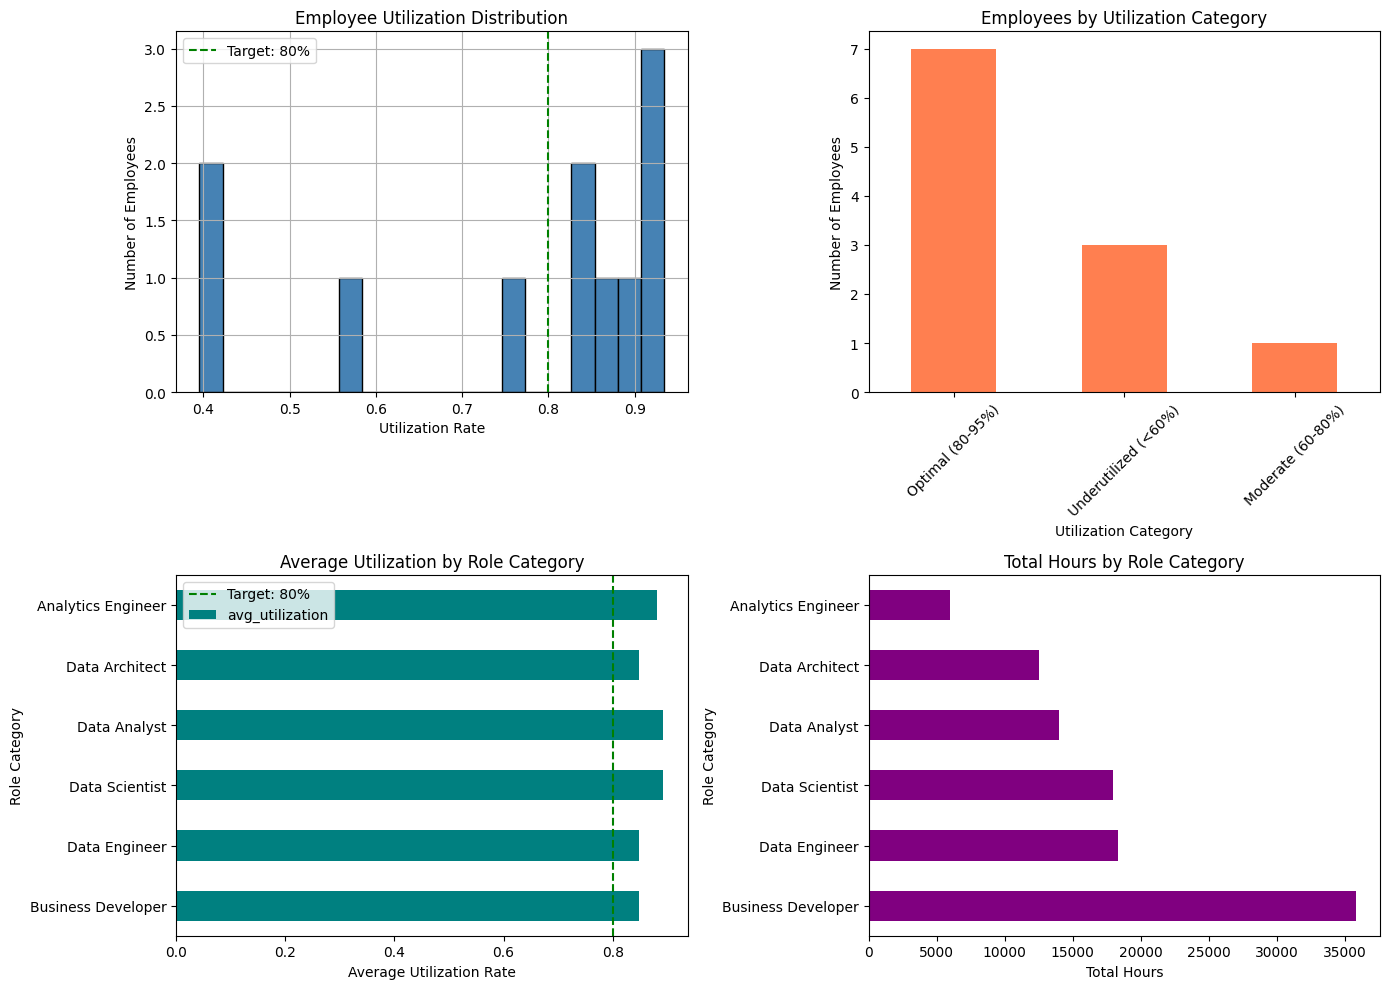

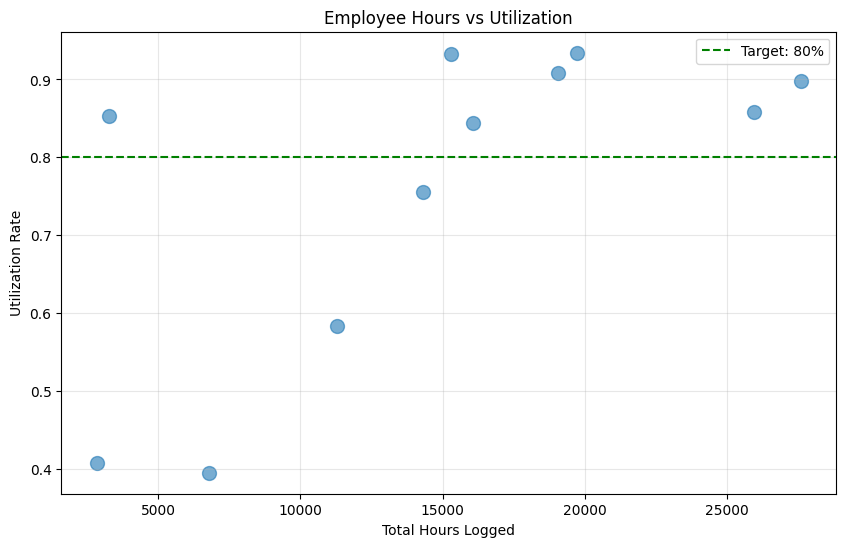

✅ Visualizations complete!


In [ ]:
# ========================================
# CELL 7: Utilization Visualizations (UPDATED)
# ========================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Employee utilization distribution
ax1 = axes[0, 0]
employee_util['utilization'].hist(bins=20, ax=ax1, color='steelblue', edgecolor='black')
ax1.axvline(0.8, color='green', linestyle='--', label='Target: 80%')
ax1.set_xlabel('Utilization Rate')
ax1.set_ylabel('Number of Employees')
ax1.set_title('Employee Utilization Distribution')
ax1.legend()

# 2. Utilization by category
ax2 = axes[0, 1]
employee_util['utilization_category'].value_counts().plot(kind='bar', ax=ax2, color='coral')
ax2.set_xlabel('Utilization Category')
ax2.set_ylabel('Number of Employees')
ax2.set_title('Employees by Utilization Category')
ax2.tick_params(axis='x', rotation=45)

# 3. Role category utilization (UPDATED COLUMN NAME)
ax3 = axes[1, 0]
role_util_sorted['avg_utilization'].plot(kind='barh', ax=ax3, color='teal')
ax3.axvline(0.8, color='green', linestyle='--', label='Target: 80%')
ax3.set_xlabel('Average Utilization Rate')
ax3.set_ylabel('Role Category')
ax3.set_title('Average Utilization by Role Category')
ax3.legend()

# 4. Hours by role category
ax4 = axes[1, 1]
role_util_sorted['total_hours'].plot(kind='barh', ax=ax4, color='purple')
ax4.set_xlabel('Total Hours')
ax4.set_ylabel('Role Category')
ax4.set_title('Total Hours by Role Category')

plt.tight_layout()
plt.show()

# Additional: Scatter plot of employee hours vs utilization
plt.figure(figsize=(10, 6))
plt.scatter(employee_util['total_hours'], employee_util['utilization'], alpha=0.6, s=100)
plt.axhline(0.8, color='green', linestyle='--', label='Target: 80%')
plt.xlabel('Total Hours Logged')
plt.ylabel('Utilization Rate')
plt.title('Employee Hours vs Utilization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("✅ Visualizations complete!")

In [ ]:
# ========================================
# CELL 8: Actionable Insights (UPDATED)
# ========================================

print("=" * 60)
print("🎯 ACTIONABLE INSIGHTS")
print("=" * 60)

# 1. Underutilized employees who could take on more work
underutilized = employee_util[employee_util['utilization'] < 0.6].sort_values('total_hours', ascending=False)

# Calculate capacity: how many more client-facing hours they could absorb to reach 80% target
TARGET_UTIL = 0.80
underutilized_capacity = underutilized.copy()
underutilized_capacity['capacity_gap'] = underutilized_capacity['total_hours'] * (TARGET_UTIL - underutilized_capacity['utilization'])

print(f"\n🔴 UNDERUTILIZED EMPLOYEES ({len(underutilized)} total):")
if len(underutilized) > 0:
    total_capacity = underutilized_capacity['capacity_gap'].sum()
    print(f"   → Can absorb ~{total_capacity:,.0f} more client-facing hours to reach 80% target")
    print(f"   → Potential revenue opportunity at $1,000/hr: ${total_capacity * 1000:,.0f}")
    
    print("\n   Top candidates for more client work:")
    display(underutilized_capacity[['total_hours', 'client_hours', 'internal_hours', 
                                      'utilization', 'capacity_gap', 'projects', 'clients']].head(5))
else:
    print("   → No underutilized employees found!")

# 2. Over-utilized employees at risk of burnout
overutilized = employee_util[employee_util['utilization'] > 0.95].sort_values('total_hours', ascending=False)

overutilized_excess = overutilized.copy()
overutilized_excess['excess_hours'] = overutilized_excess['total_hours'] * (overutilized_excess['utilization'] - TARGET_UTIL)

print(f"\n🔥 OVER-UTILIZED EMPLOYEES ({len(overutilized)} total):")
if len(overutilized) > 0:
    total_excess = overutilized_excess['excess_hours'].sum()
    print(f"   → At risk of burnout")
    print(f"   → Should redistribute ~{total_excess:,.0f} client-facing hours to reach healthy 80% target")
    
    print("\n   Immediate attention needed:")
    display(overutilized_excess[['total_hours', 'client_hours', 'internal_hours', 
                                   'utilization', 'excess_hours', 'projects', 'clients']].head(5))
else:
    print("   → No over-utilized employees found!")

# 3. Optimal range employees
optimal = employee_util[
    (employee_util['utilization'] >= 0.8) & 
    (employee_util['utilization'] <= 0.95)
]
print(f"\n✅ OPTIMALLY UTILIZED EMPLOYEES ({len(optimal)} total):")
print(f"   → {len(optimal) / len(employee_util) * 100:.1f}% of workforce in healthy range (80-95%)")

if len(optimal) > 0:
    print("\n   Sample of well-balanced employees:")
    display(optimal[['total_hours', 'client_hours', 'internal_hours', 
                      'utilization', 'billability', 'projects']].head(5))

# 4. Overall workforce summary
print("\n" + "=" * 60)
print("📊 WORKFORCE SUMMARY")
print("=" * 60)

total_workforce_hours = employee_util['total_hours'].sum()
total_client_hours = employee_util['client_hours'].sum()
total_internal_hours = employee_util['internal_hours'].sum()
overall_util = total_client_hours / total_workforce_hours

print(f"\nOverall Metrics:")
print(f"   Total workforce hours: {total_workforce_hours:,.0f}")
print(f"   Client-facing hours: {total_client_hours:,.0f} ({total_client_hours/total_workforce_hours:.1%})")
print(f"   Internal hours: {total_internal_hours:,.0f} ({total_internal_hours/total_workforce_hours:.1%})")
print(f"   Overall utilization: {overall_util:.1%}")
print(f"   Target utilization: {TARGET_UTIL:.1%}")

if overall_util < TARGET_UTIL:
    gap = total_workforce_hours * (TARGET_UTIL - overall_util)
    print(f"\n   ⚠️  Company is UNDERUTILIZED by {(TARGET_UTIL - overall_util):.1%}")
    print(f"   → Need {gap:,.0f} more client-facing hours to reach target")
    print(f"   → Potential revenue at $1,000/hr: ${gap * 1000:,.0f}")
elif overall_util > 0.95:
    excess = total_workforce_hours * (overall_util - TARGET_UTIL)
    print(f"\n   🔥 Company is OVER-UTILIZED by {(overall_util - TARGET_UTIL):.1%}")
    print(f"   → Risk of burnout! Need to hire or reduce {excess:,.0f} client hours")
else:
    print(f"\n   ✅ Company utilization is HEALTHY!")

# 5. Role-specific insights (UPDATED COLUMN NAMES)
print("\n" + "=" * 60)
print("👔 ROLE-SPECIFIC INSIGHTS")
print("=" * 60)

for role, row in role_util_sorted.iterrows():
    util = row['avg_utilization']  # UPDATED
    bill = row['avg_billability']   # UPDATED
    
    if util < 0.7:
        status = "🔴 UNDERUTILIZED"
        action = f"Employees in {role} have low utilization - consider training/upskilling or reallocating"
    elif util > 0.9:
        status = "🔥 HIGH DEMAND"
        action = f"Consider hiring more {role}s or raising rates (current: ${row['avg_hourly_rate']:.0f}/hr)"
    else:
        status = "✅ BALANCED"
        action = "Maintain current strategy"
    
    print(f"\n{role}:")
    print(f"   {status}")
    print(f"   Avg Utilization: {util:.1%} | Avg Billability: {bill:.1%}")
    print(f"   {row['employees']:.0f} employees, {row['total_hours']:,.0f} hours, ${row['avg_hourly_rate']:.0f}/hr avg")
    print(f"   → {action}")

# 6. Rebalancing recommendations
print("\n" + "=" * 60)
print("⚖️  REBALANCING RECOMMENDATIONS")
print("=" * 60)

if len(underutilized) > 0 and len(overutilized) > 0:
    print("\n✅ Opportunity: Redistribute work from over-utilized to under-utilized employees")
    print(f"   Hours to redistribute: {min(total_capacity, total_excess):,.0f}")
    print(f"\n   FROM (over-utilized):")
    print(overutilized_excess[['total_hours', 'utilization', 'excess_hours', 'projects']].head(3).to_string())
    print(f"\n   TO (under-utilized):")
    print(underutilized_capacity[['total_hours', 'utilization', 'capacity_gap', 'projects']].head(3).to_string())
elif len(underutilized) > 0:
    print("\n📈 Focus on sales/marketing to fill underutilized capacity")
    print(f"   Available capacity: {total_capacity:,.0f} hours")
elif len(overutilized) > 0:
    print("\n👥 Consider hiring to reduce overutilization")
    print(f"   Excess hours: {total_excess:,.0f}")
else:
    print("\n✅ Workforce is well-balanced!")

print("\n✅ Insights generated!")

🎯 ACTIONABLE INSIGHTS

🔴 UNDERUTILIZED EMPLOYEES (3 total):
   → Can absorb ~6,300 more client-facing hours to reach 80% target
   → Potential revenue opportunity at $1,000/hr: $6,300,300

   Top candidates for more client work:


,total_hours,client_hours,internal_hours,utilization,capacity_gap,projects,clients
user_id,,,,,,,
5f437e3d9decb91192e3784a,11280.25,6579.5,4700.75,0.583276,2444.7,12,8
64e5f63d97f5910c716406b8,6777.50,2679.0,4098.50,0.395278,2743.0,12,5
6569cd007deb44467624660e,2837.00,1157.0,1680.00,0.407825,1112.6,7,5



🔥 OVER-UTILIZED EMPLOYEES (0 total):
   → No over-utilized employees found!

✅ OPTIMALLY UTILIZED EMPLOYEES (7 total):
   → 63.6% of workforce in healthy range (80-95%)

   Sample of well-balanced employees:


,total_hours,client_hours,internal_hours,utilization,billability,projects
user_id,,,,,,
5f437ae67d26442bf5452ecd,25948.05,22279.050000,3669.000000,0.858602,0.997756,24
5f7c718cf3fda011462c67c1,19054.50,17312.000000,1742.500000,0.908552,1.000000,16
61e06b0375015b508b28241b,27598.10,24773.516667,2824.583333,0.897653,0.996771,14
638dc19ed9c69c33cb579f6b,16073.00,13577.000000,2496.000000,0.844709,0.992782,13
640f2ad98c3e1105ccb78609,19741.00,18444.000000,1297.000000,0.934299,0.991650,7



📊 WORKFORCE SUMMARY

Overall Metrics:
   Total workforce hours: 162,207
   Client-facing hours: 134,684 (83.0%)
   Internal hours: 27,523 (17.0%)
   Overall utilization: 83.0%
   Target utilization: 80.0%

   ✅ Company utilization is HEALTHY!

👔 ROLE-SPECIFIC INSIGHTS

Business Developer:
   ✅ BALANCED
   Avg Utilization: 84.8% | Avg Billability: 99.3%
   10 employees, 35,807 hours, $1355/hr avg
   → Maintain current strategy

Data Engineer:
   ✅ BALANCED
   Avg Utilization: 84.8% | Avg Billability: 99.3%
   9 employees, 18,373 hours, $1245/hr avg
   → Maintain current strategy

Data Scientist:
   ✅ BALANCED
   Avg Utilization: 89.2% | Avg Billability: 99.5%
   10 employees, 17,964 hours, $1175/hr avg
   → Maintain current strategy

Data Analyst:
   ✅ BALANCED
   Avg Utilization: 89.1% | Avg Billability: 99.5%
   9 employees, 14,015 hours, $1151/hr avg
   → Maintain current strategy

Data Architect:
   ✅ BALANCED
   Avg Utilization: 84.7% | Avg Billability: 99.6%
   6 employees, 12,50

In [ ]:
# ========================================
# CELL 9: Client Profitability Analysis
# ========================================

print("=" * 60)
print("CLIENT PROFITABILITY ANALYSIS")
print("=" * 60)

# ============================================
# PART A: CLIENT-LEVEL METRICS
# ============================================

print("\n📊 PART A: CLIENT PROFITABILITY METRICS")
print("-" * 60)

# Aggregate by client (exclude Internal)
client_facts = fact[~fact['is_internal']].copy()

client_profitability = client_facts.groupby(['client_id', 'client_anon']).agg({
    'hours': 'sum',
    'client_facing_hours': 'sum',
    'internal_hours': 'sum',
    'billable_hours_final': 'sum',
    'projected_billings': 'sum',
    'hourly_rate': 'mean',
    'user_id': 'nunique',
    'project_id': 'nunique',
    'time_entry_id': 'nunique'
}).rename(columns={
    'hours': 'total_hours',
    'client_facing_hours': 'client_hours',
    'internal_hours': 'internal_hours',
    'billable_hours_final': 'billable_hours',
    'projected_billings': 'estimated_revenue',
    'hourly_rate': 'avg_hourly_rate',
    'user_id': 'employees',
    'project_id': 'projects',
    'time_entry_id': 'time_entries'
})

# Calculate key metrics
client_profitability['utilization'] = client_profitability['client_hours'] / client_profitability['total_hours']
client_profitability['billability'] = client_profitability['billable_hours'] / client_profitability['client_hours']
client_profitability['revenue_per_hour'] = client_profitability['estimated_revenue'] / client_profitability['total_hours']
client_profitability['hours_pct'] = client_profitability['total_hours'] / client_profitability['total_hours'].sum()

# Categorize clients
def categorize_rate(rate):
    if pd.isna(rate):
        return 'No Rate Data'
    elif rate < 800:
        return 'Low Rate (<$800)'
    elif rate < 1200:
        return 'Medium Rate ($800-1200)'
    else:
        return 'High Rate (>$1200)'

def categorize_client_value(row):
    """
    Classify clients into quadrants:
    - Stars: High utilization (>80%) + High rate (>$1200)
    - Cash Cows: High rate but lower utilization
    - Workhorses: High utilization but lower rate
    - Review: Low utilization + Low rate
    """
    util = row['utilization']
    rate = row['avg_hourly_rate']
    
    if pd.isna(util) or pd.isna(rate):
        return 'Unknown'
    
    high_util = util >= 0.8
    high_rate = rate >= 1200
    
    if high_util and high_rate:
        return '⭐ Star (High Util + High Rate)'
    elif high_rate and not high_util:
        return '💰 Cash Cow (High Rate, Lower Util)'
    elif high_util and not high_rate:
        return '🐴 Workhorse (High Util, Lower Rate)'
    else:
        return '⚠️ Review (Low Util + Low Rate)'

client_profitability['rate_category'] = client_profitability['avg_hourly_rate'].apply(categorize_rate)
client_profitability['client_segment'] = client_profitability.apply(categorize_client_value, axis=1)

# Sort by estimated revenue
client_profitability_sorted = client_profitability.sort_values('estimated_revenue', ascending=False)

print(f"\nTotal clients analyzed: {len(client_profitability)}")
print(f"Total estimated revenue: ${client_profitability['estimated_revenue'].sum():,.0f}")
print(f"Average hourly rate: ${client_profitability['avg_hourly_rate'].mean():,.0f}")

print(f"\nClient Segmentation:")
print(client_profitability['client_segment'].value_counts())

print(f"\nTop 20 Clients by Revenue:")
display(client_profitability_sorted[[
    'estimated_revenue', 'total_hours', 'billable_hours', 'avg_hourly_rate',
    'utilization', 'billability', 'revenue_per_hour', 'client_segment',
    'employees', 'projects'
]].head(20))

# ============================================
# PART B: PROBLEM CLIENTS (Low Util + Low Rate)
# ============================================

print("\n" + "=" * 60)
print("⚠️ PART B: PROBLEM CLIENTS (Low Utilization + Low Rates)")
print("-" * 60)

problem_clients = client_profitability[
    (client_profitability['utilization'] < 0.8) & 
    (client_profitability['avg_hourly_rate'] < 1000)
].sort_values('total_hours', ascending=False)

if len(problem_clients) > 0:
    total_problem_hours = problem_clients['total_hours'].sum()
    total_problem_revenue = problem_clients['estimated_revenue'].sum()
    
    print(f"\nProblem clients: {len(problem_clients)}")
    print(f"Total hours consumed: {total_problem_hours:,.0f} ({total_problem_hours/client_profitability['total_hours'].sum():.1%} of client work)")
    print(f"Total revenue: ${total_problem_revenue:,.0f}")
    print(f"Average rate: ${problem_clients['avg_hourly_rate'].mean():,.0f}/hr")
    print(f"Average utilization: {problem_clients['utilization'].mean():.1%}")
    
    print(f"\n⚠️ Consider reviewing these client relationships:")
    display(problem_clients[[
        'total_hours', 'estimated_revenue', 'avg_hourly_rate', 'utilization',
        'billability', 'revenue_per_hour', 'projects'
    ]].head(10))
else:
    print("\n✅ No problem clients found!")

# ============================================
# PART C: STAR CLIENTS (High Util + High Rate)
# ============================================

print("\n" + "=" * 60)
print("⭐ PART C: STAR CLIENTS (High Utilization + High Rates)")
print("-" * 60)

star_clients = client_profitability[
    (client_profitability['utilization'] >= 0.8) & 
    (client_profitability['avg_hourly_rate'] >= 1200)
].sort_values('estimated_revenue', ascending=False)

if len(star_clients) > 0:
    total_star_hours = star_clients['total_hours'].sum()
    total_star_revenue = star_clients['estimated_revenue'].sum()
    
    print(f"\nStar clients: {len(star_clients)}")
    print(f"Total hours: {total_star_hours:,.0f} ({total_star_hours/client_profitability['total_hours'].sum():.1%} of client work)")
    print(f"Total revenue: ${total_star_revenue:,.0f} ({total_star_revenue/client_profitability['estimated_revenue'].sum():.1%} of revenue)")
    print(f"Average rate: ${star_clients['avg_hourly_rate'].mean():,.0f}/hr")
    print(f"Average utilization: {star_clients['utilization'].mean():.1%}")
    
    print(f"\n⭐ Protect and grow these relationships:")
    display(star_clients[[
        'total_hours', 'estimated_revenue', 'avg_hourly_rate', 'utilization',
        'billability', 'revenue_per_hour', 'projects'
    ]].head(10))
else:
    print("\n⚠️ No star clients found - opportunity to improve!")

# ============================================
# PART D: RATE OPTIMIZATION OPPORTUNITIES
# ============================================

print("\n" + "=" * 60)
print("💰 PART D: RATE OPTIMIZATION OPPORTUNITIES")
print("-" * 60)

# Workhorses: High utilization but low rates = rate increase opportunity
workhorses = client_profitability[
    (client_profitability['utilization'] >= 0.8) & 
    (client_profitability['avg_hourly_rate'] < 1000)
].sort_values('total_hours', ascending=False)

if len(workhorses) > 0:
    # Calculate opportunity if rates increased to $1200
    target_rate = 1200
    workhorses_opp = workhorses.copy()
    workhorses_opp['current_revenue'] = workhorses_opp['estimated_revenue']
    workhorses_opp['potential_revenue'] = workhorses_opp['billable_hours'] * target_rate
    workhorses_opp['revenue_upside'] = workhorses_opp['potential_revenue'] - workhorses_opp['current_revenue']
    
    total_upside = workhorses_opp['revenue_upside'].sum()
    
    print(f"\n🐴 Workhorse clients (high effort, lower rates): {len(workhorses)}")
    print(f"Current revenue: ${workhorses_opp['current_revenue'].sum():,.0f}")
    print(f"Potential revenue at ${target_rate}/hr: ${workhorses_opp['potential_revenue'].sum():,.0f}")
    print(f"Revenue upside: ${total_upside:,.0f}")
    
    print(f"\n💰 Top rate increase opportunities:")
    display(workhorses_opp[[
        'total_hours', 'billable_hours', 'avg_hourly_rate', 'utilization',
        'current_revenue', 'potential_revenue', 'revenue_upside'
    ]].head(10))
else:
    print("\n✅ All high-utilization clients already have good rates!")

# ============================================
# PART E: CLIENT CONCENTRATION RISK
# ============================================

print("\n" + "=" * 60)
print("📊 PART E: CLIENT CONCENTRATION ANALYSIS")
print("-" * 60)

# Calculate cumulative revenue share
client_by_revenue = client_profitability.sort_values('estimated_revenue', ascending=False).copy()
client_by_revenue['revenue_share'] = client_by_revenue['estimated_revenue'] / client_by_revenue['estimated_revenue'].sum()
client_by_revenue['cumulative_revenue_share'] = client_by_revenue['revenue_share'].cumsum()

# Find concentration thresholds
top_1_pct = (client_by_revenue['cumulative_revenue_share'] <= 0.01).sum()
top_5_pct = (client_by_revenue['cumulative_revenue_share'] <= 0.05).sum()
top_20_pct = (client_by_revenue['cumulative_revenue_share'] <= 0.20).sum()
top_50_pct = (client_by_revenue['cumulative_revenue_share'] <= 0.50).sum()
top_80_pct = (client_by_revenue['cumulative_revenue_share'] <= 0.80).sum()

print(f"\nRevenue Concentration:")
print(f"  Top 1 client(s) = {(client_by_revenue['cumulative_revenue_share'].iloc[0] if len(client_by_revenue) > 0 else 0):.1%} of revenue")
print(f"  Top {min(5, len(client_by_revenue))} clients = {(client_by_revenue['cumulative_revenue_share'].iloc[min(4, len(client_by_revenue)-1)] if len(client_by_revenue) > 0 else 0):.1%} of revenue")
print(f"  Top {top_50_pct} clients = 50% of revenue")
print(f"  Top {top_80_pct} clients = 80% of revenue")

if top_50_pct <= 3:
    print(f"\n  ⚠️  HIGH CONCENTRATION RISK: {top_50_pct} clients drive 50% of revenue")
elif top_50_pct <= 10:
    print(f"\n  ⚠️  MODERATE CONCENTRATION: {top_50_pct} clients drive 50% of revenue")
else:
    print(f"\n  ✅ DIVERSIFIED: {top_50_pct} clients needed for 50% of revenue")

print(f"\nTop 10 Clients by Revenue Share:")
display(client_by_revenue[['estimated_revenue', 'revenue_share', 'cumulative_revenue_share', 
                            'total_hours', 'avg_hourly_rate', 'client_segment']].head(10))

print("\n✅ Client profitability analysis complete!")

CLIENT PROFITABILITY ANALYSIS

📊 PART A: CLIENT PROFITABILITY METRICS
------------------------------------------------------------

Total clients analyzed: 38
Total estimated revenue: $159,679,309
Average hourly rate: $1,264

Client Segmentation:
client_segment
⭐ Star (High Util + High Rate)         16
Unknown                                12
🐴 Workhorse (High Util, Lower Rate)    10
Name: count, dtype: int64

Top 20 Clients by Revenue:


,,estimated_revenue,total_hours,billable_hours,avg_hourly_rate,utilization,billability,revenue_per_hour,client_segment,employees,projects
client_id,client_anon,,,,,,,,,,
6038e369b5d4135b129bb832,Sullivan PLC,62207250.0,48790.0,48790.0,1275.000000,1.0,1.0,1275.000000,⭐ Star (High Util + High Rate),4,2
642c320f77aed916ab7b1d4a,Barnes and Sons,21922080.0,13408.0,13408.0,1635.000000,1.0,1.0,1635.000000,⭐ Star (High Util + High Rate),2,2
613b393eac2a7406faeb54f1,Ortega Group,13578084.0,12216.0,12216.0,1333.800000,1.0,1.0,1111.500000,⭐ Star (High Util + High Rate),5,8
65eecc3f36768531547fc52e,Joseph and Sons,11523875.0,10846.0,10846.0,1062.500000,1.0,1.0,1062.500000,"🐴 Workhorse (High Util, Lower Rate)",3,2
60dac2573e575122aec33423,Gonzalez-Miller,7057800.0,5228.0,5228.0,1350.000000,1.0,1.0,1350.000000,⭐ Star (High Util + High Rate),1,2
615df4c8939aa5668fb288ec,"Gamble, Summers and Bailey",7049800.0,5584.0,5584.0,1262.500000,1.0,1.0,1262.500000,⭐ Star (High Util + High Rate),1,2
6426b575775d020dc93ac90e,"Rogers, Perry and Ramsey",6638775.0,4023.5,4023.5,1650.000000,1.0,1.0,1650.000000,⭐ Star (High Util + High Rate),2,2
66fe75bfcdc43032a10267d7,"Ramirez, Rodriguez and Gonzalez",4266000.0,2844.0,2844.0,1500.000000,1.0,1.0,1500.000000,⭐ Star (High Util + High Rate),3,1
66c73f3bad27092b46167633,"Harvey, Collins and Walker",3788400.0,2706.0,2706.0,1400.000000,1.0,1.0,1400.000000,⭐ Star (High Util + High Rate),3,1



⚠️ PART B: PROBLEM CLIENTS (Low Utilization + Low Rates)
------------------------------------------------------------

✅ No problem clients found!

⭐ PART C: STAR CLIENTS (High Utilization + High Rates)
------------------------------------------------------------

Star clients: 16
Total hours: 103,332 (76.7% of client work)
Total revenue: $136,886,354 (85.7% of revenue)
Average rate: $1,412/hr
Average utilization: 100.0%

⭐ Protect and grow these relationships:


,,total_hours,estimated_revenue,avg_hourly_rate,utilization,billability,revenue_per_hour,projects
client_id,client_anon,,,,,,,
6038e369b5d4135b129bb832,Sullivan PLC,48790.0,62207250.0,1275.0,1.0,1.0,1275.0,2
642c320f77aed916ab7b1d4a,Barnes and Sons,13408.0,21922080.0,1635.0,1.0,1.0,1635.0,2
613b393eac2a7406faeb54f1,Ortega Group,12216.0,13578084.0,1333.8,1.0,1.0,1111.5,8
60dac2573e575122aec33423,Gonzalez-Miller,5228.0,7057800.0,1350.0,1.0,1.0,1350.0,2
615df4c8939aa5668fb288ec,"Gamble, Summers and Bailey",5584.0,7049800.0,1262.5,1.0,1.0,1262.5,2
6426b575775d020dc93ac90e,"Rogers, Perry and Ramsey",4023.5,6638775.0,1650.0,1.0,1.0,1650.0,2
66fe75bfcdc43032a10267d7,"Ramirez, Rodriguez and Gonzalez",2844.0,4266000.0,1500.0,1.0,1.0,1500.0,1
66c73f3bad27092b46167633,"Harvey, Collins and Walker",2706.0,3788400.0,1400.0,1.0,1.0,1400.0,1
5f68ec2f5d3b7b2b1d62ee6a,"Rice, Strickland and Soto",2113.0,2746900.0,1300.0,1.0,1.0,1300.0,2



💰 PART D: RATE OPTIMIZATION OPPORTUNITIES
------------------------------------------------------------

🐴 Workhorse clients (high effort, lower rates): 3
Current revenue: $3,719,450
Potential revenue at $1200/hr: $4,819,200
Revenue upside: $1,099,750

💰 Top rate increase opportunities:


,,total_hours,billable_hours,avg_hourly_rate,utilization,current_revenue,potential_revenue,revenue_upside
client_id,client_anon,,,,,,,
60c255c97a48f36236eae371,"Campbell, Johnson and Smith",3052.0,3052.0,950.0,1.0,2899400.0,3662400.0,763000.0
667a7017842d3958e3f8947d,"Lee, Freeman and Jones",951.0,951.0,850.0,1.0,808350.0,1141200.0,332850.0
667bd75aa932d14bad6269a9,"Robinson, Kaufman and Mills",13.0,13.0,900.0,1.0,11700.0,15600.0,3900.0



📊 PART E: CLIENT CONCENTRATION ANALYSIS
------------------------------------------------------------

Revenue Concentration:
  Top 1 client(s) = 39.0% of revenue
  Top 5 clients = 72.8% of revenue
  Top 1 clients = 50% of revenue
  Top 6 clients = 80% of revenue

  ⚠️  HIGH CONCENTRATION RISK: 1 clients drive 50% of revenue

Top 10 Clients by Revenue Share:


,,estimated_revenue,revenue_share,cumulative_revenue_share,total_hours,avg_hourly_rate,client_segment
client_id,client_anon,,,,,,
6038e369b5d4135b129bb832,Sullivan PLC,62207250.0,0.389576,0.389576,48790.0,1275.0,⭐ Star (High Util + High Rate)
642c320f77aed916ab7b1d4a,Barnes and Sons,21922080.0,0.137288,0.526864,13408.0,1635.0,⭐ Star (High Util + High Rate)
613b393eac2a7406faeb54f1,Ortega Group,13578084.0,0.085033,0.611898,12216.0,1333.8,⭐ Star (High Util + High Rate)
65eecc3f36768531547fc52e,Joseph and Sons,11523875.0,0.072169,0.684067,10846.0,1062.5,"🐴 Workhorse (High Util, Lower Rate)"
60dac2573e575122aec33423,Gonzalez-Miller,7057800.0,0.044200,0.728266,5228.0,1350.0,⭐ Star (High Util + High Rate)
615df4c8939aa5668fb288ec,"Gamble, Summers and Bailey",7049800.0,0.044150,0.772416,5584.0,1262.5,⭐ Star (High Util + High Rate)
6426b575775d020dc93ac90e,"Rogers, Perry and Ramsey",6638775.0,0.041576,0.813992,4023.5,1650.0,⭐ Star (High Util + High Rate)
66fe75bfcdc43032a10267d7,"Ramirez, Rodriguez and Gonzalez",4266000.0,0.026716,0.840708,2844.0,1500.0,⭐ Star (High Util + High Rate)
66c73f3bad27092b46167633,"Harvey, Collins and Walker",3788400.0,0.023725,0.864433,2706.0,1400.0,⭐ Star (High Util + High Rate)



✅ Client profitability analysis complete!


C:\Users\oseic\AppData\Local\Temp\ipykernel_24368\424574542.py:92: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\oseic\AppData\Local\Temp\ipykernel_24368\424574542.py:92: UserWarning: Glyph 128052 (\N{HORSE FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\oseic\Downloads\Data_Edge_Internal_Data\data_edge_streamlit_starter\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\oseic\Downloads\Data_Edge_Internal_Data\data_edge_streamlit_starter\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128052 (\N{HORSE FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


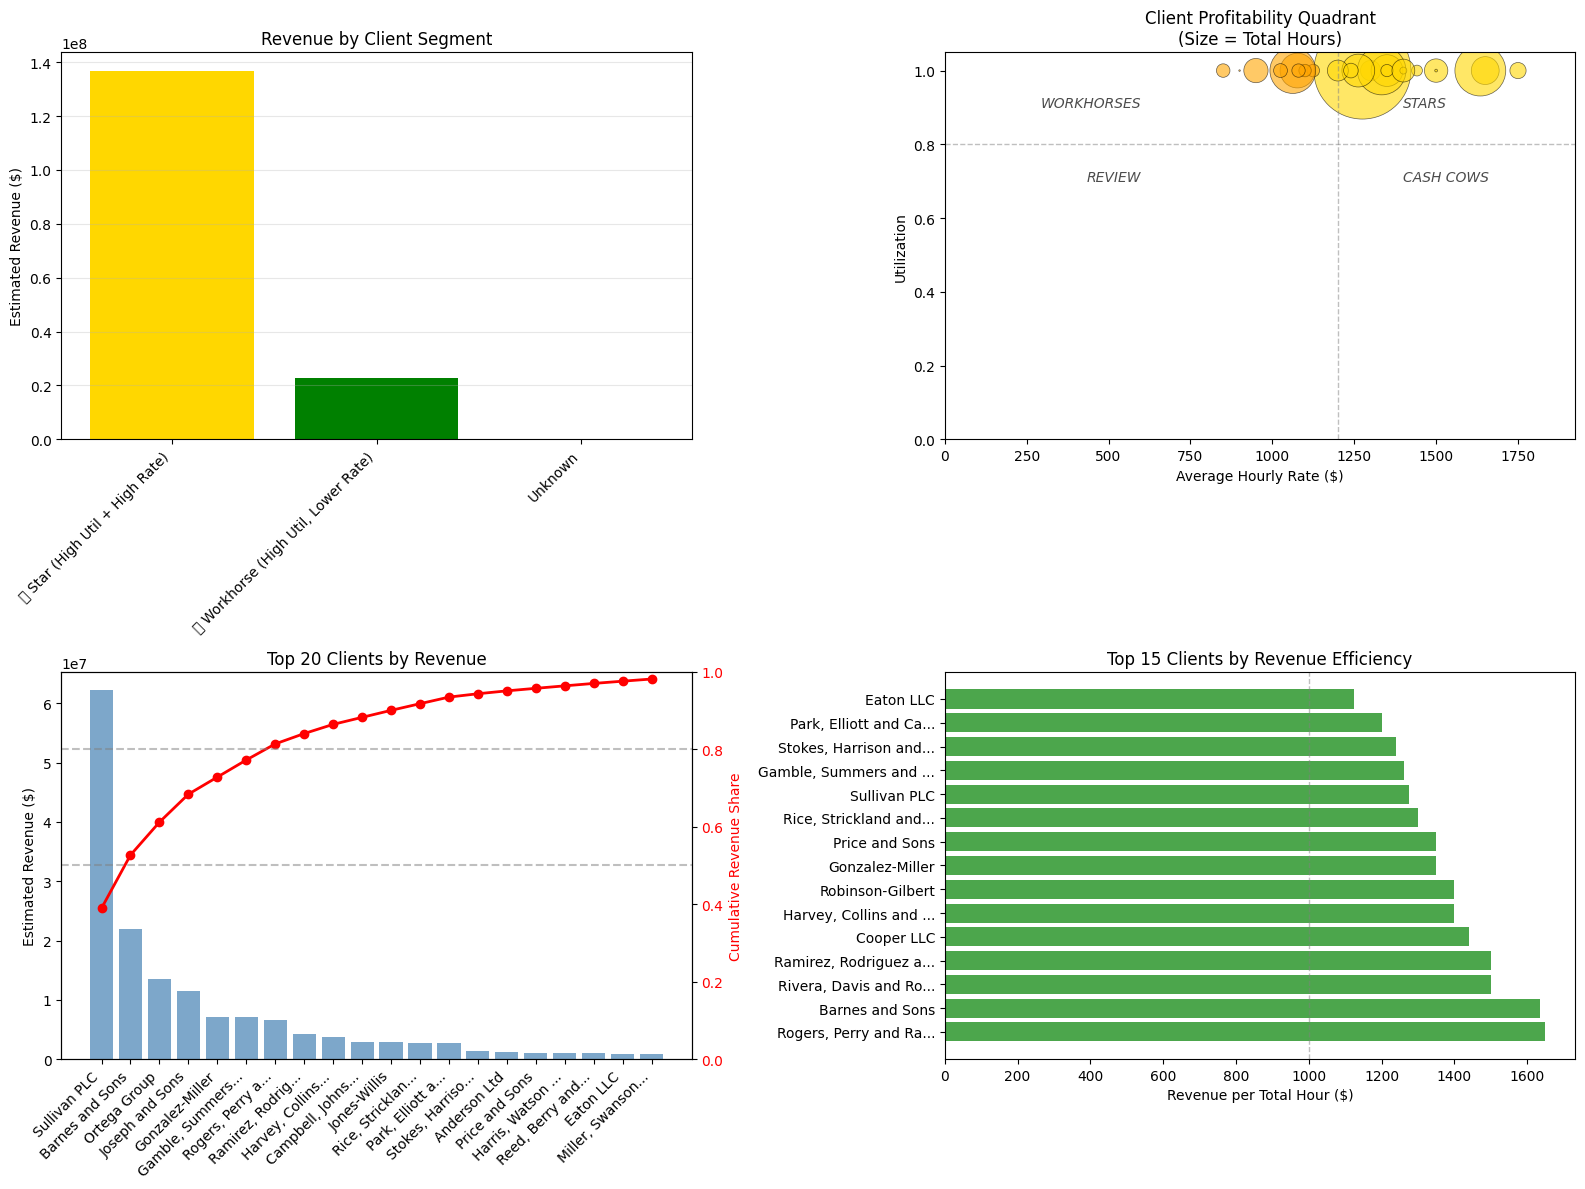


📊 CLIENT SEGMENT SUMMARY

Segment Performance:


,num_clients,total_hours,estimated_revenue,avg_hourly_rate,utilization,billability,avg_revenue_per_client,revenue_pct
client_segment,,,,,,,,
⭐ Star (High Util + High Rate),16,103332.500000,136886354.0,1411.747917,1.0,1.000000,8555397.125,0.857258
"🐴 Workhorse (High Util, Lower Rate)",10,25416.000000,22792955.0,1026.916667,1.0,1.000000,2279295.500,0.142742
Unknown,12,5935.566667,0.0,NaN,1.0,0.916667,0.000,0.000000



✅ Visualizations complete!


In [ ]:
# ========================================
# CELL 10: Client Profitability Visualizations
# ========================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Client Segment Distribution (by revenue)
ax1 = axes[0, 0]
segment_revenue = client_profitability.groupby('client_segment')['estimated_revenue'].sum().sort_values(ascending=False)
colors_seg = ['gold', 'green', 'orange', 'red', 'gray']
ax1.bar(range(len(segment_revenue)), segment_revenue.values, color=colors_seg[:len(segment_revenue)])
ax1.set_xticks(range(len(segment_revenue)))
ax1.set_xticklabels(segment_revenue.index, rotation=45, ha='right')
ax1.set_ylabel('Estimated Revenue ($)')
ax1.set_title('Revenue by Client Segment')
ax1.grid(axis='y', alpha=0.3)

# 2. Utilization vs Hourly Rate Scatter (Client Quadrant Analysis)
ax2 = axes[0, 1]
scatter_data = client_profitability[client_profitability['avg_hourly_rate'].notna()].copy()
colors = scatter_data['client_segment'].map({
    '⭐ Star (High Util + High Rate)': 'gold',
    '💰 Cash Cow (High Rate, Lower Util)': 'green',
    '🐴 Workhorse (High Util, Lower Rate)': 'orange',
    '⚠️ Review (Low Util + Low Rate)': 'red',
    'Unknown': 'gray'
})

# Size by total hours
sizes = scatter_data['total_hours'] / 10

ax2.scatter(scatter_data['avg_hourly_rate'], scatter_data['utilization'], 
           c=colors, s=sizes, alpha=0.6, edgecolors='black', linewidth=0.5)

# Quadrant lines
ax2.axhline(0.8, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.axvline(1200, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Labels
ax2.set_xlabel('Average Hourly Rate ($)')
ax2.set_ylabel('Utilization')
ax2.set_title('Client Profitability Quadrant\n(Size = Total Hours)')
ax2.set_xlim(0, scatter_data['avg_hourly_rate'].max() * 1.1)
ax2.set_ylim(0, 1.05)

# Quadrant labels
ax2.text(1400, 0.9, 'STARS', fontsize=10, ha='left', style='italic', alpha=0.7)
ax2.text(1400, 0.7, 'CASH COWS', fontsize=10, ha='left', style='italic', alpha=0.7)
ax2.text(600, 0.9, 'WORKHORSES', fontsize=10, ha='right', style='italic', alpha=0.7)
ax2.text(600, 0.7, 'REVIEW', fontsize=10, ha='right', style='italic', alpha=0.7)

# 3. Pareto Chart - Revenue Concentration
ax3 = axes[1, 0]
client_by_revenue_plot = client_profitability.sort_values('estimated_revenue', ascending=False).head(20)
x_pos = np.arange(len(client_by_revenue_plot))

ax3.bar(x_pos, client_by_revenue_plot['estimated_revenue'].values, color='steelblue', alpha=0.7)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                     for name in client_by_revenue_plot.index.get_level_values('client_anon')], 
                    rotation=45, ha='right')
ax3.set_ylabel('Estimated Revenue ($)')
ax3.set_title('Top 20 Clients by Revenue')

# Cumulative line
ax3_twin = ax3.twinx()
cumsum = client_by_revenue_plot['estimated_revenue'].cumsum() / client_profitability['estimated_revenue'].sum()
ax3_twin.plot(x_pos, cumsum.values, color='red', marker='o', linewidth=2)
ax3_twin.set_ylabel('Cumulative Revenue Share', color='red')
ax3_twin.tick_params(axis='y', labelcolor='red')
ax3_twin.set_ylim(0, 1)
ax3_twin.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax3_twin.axhline(0.8, color='gray', linestyle='--', alpha=0.5)

# 4. Revenue per Hour by Client
ax4 = axes[1, 1]
top_clients_eff = client_profitability.sort_values('revenue_per_hour', ascending=False).head(15)
colors_eff = ['green' if r > 1000 else 'orange' if r > 500 else 'red' 
              for r in top_clients_eff['revenue_per_hour']]

ax4.barh(range(len(top_clients_eff)), top_clients_eff['revenue_per_hour'].values, color=colors_eff, alpha=0.7)
ax4.set_yticks(range(len(top_clients_eff)))
ax4.set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                     for name in top_clients_eff.index.get_level_values('client_anon')])
ax4.set_xlabel('Revenue per Total Hour ($)')
ax4.set_title('Top 15 Clients by Revenue Efficiency')
ax4.axvline(1000, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Additional: Client segment summary table visualization
print("\n" + "=" * 60)
print("📊 CLIENT SEGMENT SUMMARY")
print("=" * 60)

segment_summary = client_profitability.groupby('client_segment').agg({
    'total_hours': ['count', 'sum'],  # count gives us number of clients
    'estimated_revenue': 'sum',
    'avg_hourly_rate': 'mean',
    'utilization': 'mean',
    'billability': 'mean'
})

# Flatten multi-level columns
segment_summary.columns = ['num_clients', 'total_hours', 'estimated_revenue', 
                            'avg_hourly_rate', 'utilization', 'billability']

segment_summary['avg_revenue_per_client'] = segment_summary['estimated_revenue'] / segment_summary['num_clients']
segment_summary['revenue_pct'] = segment_summary['estimated_revenue'] / segment_summary['estimated_revenue'].sum()

print("\nSegment Performance:")
display(segment_summary.sort_values('estimated_revenue', ascending=False))

print("\n✅ Visualizations complete!")

In [ ]:
# ========================================
# DIAGNOSTIC: Investigate Unknown Clients
# ========================================

print("=" * 60)
print("🔍 INVESTIGATING 'UNKNOWN' CLIENTS")
print("=" * 60)

# Filter for Unknown segment
unknown_clients = client_profitability[client_profitability['client_segment'] == 'Unknown']

print(f"\nUnknown clients: {len(unknown_clients)}")
print(f"Total hours: {unknown_clients['total_hours'].sum():,.0f}")

# Check what's missing
print(f"\n📊 Missing Data Breakdown:")
print(f"  Missing avg_hourly_rate: {unknown_clients['avg_hourly_rate'].isna().sum()} clients")
print(f"  Missing utilization: {unknown_clients['utilization'].isna().sum()} clients")
print(f"  Missing billable_hours: {unknown_clients['billable_hours'].isna().sum()} clients")

# Show the unknown clients
print(f"\n📋 Unknown Clients Detail:")
display(unknown_clients[[
    'total_hours', 'client_hours', 'billable_hours', 'estimated_revenue',
    'avg_hourly_rate', 'utilization', 'billability', 'employees', 'projects'
]].sort_values('total_hours', ascending=False))

# Trace back to fact table - which clients have no role/rate data?
print("\n🔍 Root Cause Analysis:")

# Get the client_ids for unknown clients
unknown_client_ids = unknown_clients.index.get_level_values('client_id').tolist()

# Check fact table for these clients
unknown_in_fact = fact[
    (~fact['is_internal']) & 
    (fact['client_id'].isin(unknown_client_ids))
]

print(f"\nTime entries for Unknown clients: {len(unknown_in_fact)}")
print(f"  With role data: {unknown_in_fact['role_category_name'].notna().sum()} ({unknown_in_fact['role_category_name'].notna().mean():.1%})")
print(f"  With hourly_rate: {unknown_in_fact['hourly_rate'].notna().sum()} ({unknown_in_fact['hourly_rate'].notna().mean():.1%})")
print(f"  With industry data: {unknown_in_fact['industry_name'].notna().sum()} ({unknown_in_fact['industry_name'].notna().mean():.1%})")

# Sample projects from unknown clients
print(f"\n📁 Sample Projects from Unknown Clients:")
sample_unknown = unknown_in_fact.groupby(['client_anon', 'project_anon']).agg({
    'hours': 'sum',
    'role_category_name': 'first',
    'hourly_rate': 'first'
}).sort_values('hours', ascending=False).head(10)
display(sample_unknown)

print("\n🎯 LIKELY CAUSE:")
if unknown_in_fact['role_category_name'].isna().mean() > 0.9:
    print("   These clients have NO ROLE assignments in the roles table")
    print("   → They never matched on client_anon = name_anon join")
    print("   → ACTION: Check if these client names exist in dim__notion_roles__anonymized.csv")
elif unknown_in_fact['hourly_rate'].isna().mean() > 0.9:
    print("   These clients have roles but NO HOURLY RATES")
    print("   → ACTION: Add hourly rates to these roles in dim__notion_roles__anonymized.csv")

🔍 INVESTIGATING 'UNKNOWN' CLIENTS

Unknown clients: 12
Total hours: 5,936

📊 Missing Data Breakdown:
  Missing avg_hourly_rate: 12 clients
  Missing utilization: 0 clients
  Missing billable_hours: 0 clients

📋 Unknown Clients Detail:


,,total_hours,client_hours,billable_hours,estimated_revenue,avg_hourly_rate,utilization,billability,employees,projects
client_id,client_anon,,,,,,,,,
5f437b119decb91192e3696c,"Fernandez, Brewer and Vasquez",3027.000000,3027.000000,3027.000000,0.0,NaN,1.0,1.0,2,1
60de22d486e7ee16bcdc4f39,Roberts-Adkins,1156.000000,1156.000000,1156.000000,0.0,NaN,1.0,1.0,1,1
5f437b54d13ed94468add358,"Taylor, Simmons and Anderson",794.000000,794.000000,0.000000,0.0,NaN,1.0,0.0,7,2
5f9a78c9e16a5c5558319fb5,"Thomas, Morales and Porter",359.000000,359.000000,359.000000,0.0,NaN,1.0,1.0,1,1
679b93c45d710856f30c8295,Ward and Sons,230.000000,230.000000,230.000000,0.0,NaN,1.0,1.0,2,1
621ce09bedaba27d0a558e80,"Harper, Moore and Erickson",107.500000,107.500000,107.500000,0.0,NaN,1.0,1.0,1,1
60d2da9b4f112235499bb80e,"Clark, David and Murphy",100.050000,100.050000,100.050000,0.0,NaN,1.0,1.0,2,1
6513d62eb01ba161266f63b7,"Carr, Walton and Rose",76.000000,76.000000,76.000000,0.0,NaN,1.0,1.0,3,1
61e14193a9af6133e719603f,Roy Group,56.016667,56.016667,56.016667,0.0,NaN,1.0,1.0,1,1



🔍 Root Cause Analysis:

Time entries for Unknown clients: 868
  With role data: 68 (7.8%)
  With hourly_rate: 0 (0.0%)
  With industry data: 68 (7.8%)

📁 Sample Projects from Unknown Clients:


hours  \
client_anon                   project_anon                                        
Fernandez, Brewer and Vasquez Datadriven produktion                 3027.000000   
Roberts-Adkins                Product Insights Lead                 1156.000000   
Taylor, Simmons and Anderson  Brown, Martinez and Manning Projects   414.000000   
                              Vård av barn                           380.000000   
Thomas, Morales and Porter    DWH Thomas, Morales and Porter         359.000000   
Ward and Sons                 Geo Opp. Ass.                          230.000000   
Harper, Moore and Erickson    Tucker-White                           107.500000   
Clark, David and Murphy       Campbell, Johnson and Smith            100.050000   
Carr, Walton and Rose         AI Team Lead                            76.000000   
Roy Group                     Polar simulations                       56.016667   

                                                                    role_category_name  \
client_anon                   project_anon                                               
Fernandez, Brewer and Vasquez Datadriven produktion                               None   
Roberts-Adkins                Product Insights Lead                               None   
Taylor, Simmons and Anderson  Brown, Martinez and Manning Projects                None   
                              Vård av barn                                        None   
Thomas, Morales and Porter    DWH Thomas, Morales and Porter                      None   
Ward and Sons                 Geo Opp. Ass.                         Business Developer   
Harper, Moore and Erickson    Tucker-White                                        None   
Clark, David and Murphy       Campbell, Johnson and Smith                         None   
Carr, Walton and Rose         AI Team Lead                                        None   
Roy Group                     Polar simulations                                   None   

                                                                    hourly_rate  
client_anon                   project_anon                                       
Fernandez, Brewer and Vasquez Datadriven produktion                         NaN  
Roberts-Adkins                Product Insights Lead                         NaN  
Taylor, Simmons and Anderson  Brown, Martinez and Manning Projects          NaN  
                              Vård av barn                                  NaN  
Thomas, Morales and Porter    DWH Thomas, Morales and Porter                NaN  
Ward and Sons                 Geo Opp. Ass.                                 NaN  
Harper, Moore and Erickson    Tucker-White                                  NaN  
Clark, David and Murphy       Campbell, Johnson and Smith                   NaN  
Carr, Walton and Rose         AI Team Lead                                  NaN  
Roy Group                     Polar simulations                             NaN


🎯 LIKELY CAUSE:
   These clients have NO ROLE assignments in the roles table
   → They never matched on client_anon = name_anon join
   → ACTION: Check if these client names exist in dim__notion_roles__anonymized.csv


In [ ]:
# ========================================
# CELL 11: Internal Time Allocation Breakdown
# ========================================

print("=" * 60)
print("INTERNAL TIME ALLOCATION BREAKDOWN")
print("=" * 60)

# ============================================
# PART A: CATEGORIZE INTERNAL TIME
# ============================================

print("\n📊 PART A: INTERNAL TIME CATEGORIES")
print("-" * 60)

# Get internal/non-billable time entries
internal_time = fact[fact['is_internal']].copy()

# Define granular categories based on project names
def categorize_internal_time(row):
    """
    Categorize internal time based on project name keywords
    """
    proj_name = str(row.get('project_anon', '')).lower()
    # billable_flag = row.get('clockify_project_billable', None)  # Removed, not used
    
    # Check various keywords
    if any(kw in proj_name for kw in ['semester', 'vacation', 'semester', 'ledighet']):
        return 'Vacation/Leave'
    elif any(kw in proj_name for kw in ['sjuk', 'sick', 'vab']):
        return 'Sick Leave'
    elif any(kw in proj_name for kw in ['föräldra', 'parental']):
        return 'Parental Leave'
    elif any(kw in proj_name for kw in ['competence', 'training', 'utbildning', 'course', 'learning']):
        return 'Training/Development'
    elif any(kw in proj_name for kw in ['admin', 'administration', 'meeting', 'möte']):
        return 'Admin/Meetings'
    elif any(kw in proj_name for kw in ['interntid', 'internal', 'intern']):
        return 'General Internal'
    elif any(kw in proj_name for kw in ['obetald', 'unpaid']):
        return 'Unpaid Time'
    elif any(kw in proj_name for kw in ['sales', 'försäljning', 'pre-sales', 'proposal']):
        return 'Sales/Pre-Sales'
    elif any(kw in proj_name for kw in ['bench', 'available', 'tillgänglig']):
        return 'Bench/Available'
    else:
        return 'Other Internal'

internal_time['internal_category'] = internal_time.apply(categorize_internal_time, axis=1)

# Aggregate by category
internal_breakdown = internal_time.groupby('internal_category').agg({
    'hours': 'sum',
    'user_id': 'nunique',
    'project_id': 'nunique',
    'time_entry_id': 'nunique'
}).rename(columns={
    'hours': 'total_hours',
    'user_id': 'employees',
    'project_id': 'projects',
    'time_entry_id': 'time_entries'
})

# Calculate percentages
total_internal_hours = internal_breakdown['total_hours'].sum()
internal_breakdown['pct_of_internal'] = internal_breakdown['total_hours'] / total_internal_hours
internal_breakdown['pct_of_all_time'] = internal_breakdown['total_hours'] / fact['hours'].sum()

internal_breakdown_sorted = internal_breakdown.sort_values('total_hours', ascending=False)

print(f"\nTotal internal hours: {total_internal_hours:,.0f}")
print(f"Total hours (all): {fact['hours'].sum():,.0f}")
print(f"Internal as % of all time: {total_internal_hours / fact['hours'].sum():.1%}")

print(f"\nInternal Time Breakdown:")
display(internal_breakdown_sorted)

# ============================================
# PART B: TOP INTERNAL PROJECTS
# ============================================

print("\n" + "=" * 60)
print("📋 PART B: TOP INTERNAL PROJECTS")
print("-" * 60)

top_internal_projects = internal_time.groupby(['project_anon', 'internal_category']).agg({
    'hours': 'sum',
    'user_id': 'nunique'
}).rename(columns={
    'hours': 'total_hours',
    'user_id': 'employees'
}).sort_values('total_hours', ascending=False)

print("\nTop 20 Internal Projects:")
display(top_internal_projects.head(20))

# ============================================
# PART C: EMPLOYEE INTERNAL TIME BREAKDOWN
# ============================================

print("\n" + "=" * 60)
print("👥 PART C: EMPLOYEE INTERNAL TIME BREAKDOWN")
print("-" * 60)

employee_internal = internal_time.groupby(['user_id', 'internal_category']).agg({
    'hours': 'sum'
}).unstack(fill_value=0)

# Flatten column names
employee_internal.columns = employee_internal.columns.get_level_values(1)
employee_internal['total_internal'] = employee_internal.sum(axis=1)

# Join with overall employee stats
employee_internal_full = employee_util.merge(
    employee_internal,
    left_index=True,
    right_index=True,
    how='left'
).fillna(0)

employee_internal_full['internal_pct'] = employee_internal_full['internal_hours'] / employee_internal_full['total_hours']

employee_internal_sorted = employee_internal_full.sort_values('internal_hours', ascending=False)

print(f"\nEmployees by Internal Hours:")
display(employee_internal_sorted[[
    'total_hours', 'internal_hours', 'internal_pct', 'utilization'
] + [col for col in employee_internal.columns if col != 'total_internal']].head(15))

# ============================================
# PART D: MONTHLY TREND
# ============================================

print("\n" + "=" * 60)
print("📅 PART D: INTERNAL TIME MONTHLY TREND")
print("-" * 60)

if 'month' in internal_time.columns:
    monthly_internal = internal_time.groupby(['month', 'internal_category']).agg({
        'hours': 'sum'
    }).unstack(fill_value=0)
    
    # Flatten columns
    monthly_internal.columns = monthly_internal.columns.get_level_values(1)
    monthly_internal['total'] = monthly_internal.sum(axis=1)
    
    print("\nMonthly Internal Hours by Category (last 12 months):")
    display(monthly_internal.tail(12))
else:
    print("\n⚠️ No month data available for trending")

# ============================================
# PART E: ACTIONABLE INSIGHTS
# ============================================

print("\n" + "=" * 60)
print("🎯 PART E: INTERNAL TIME INSIGHTS")
print("=" * 60)

# Find biggest internal time consumers
biggest_categories = internal_breakdown_sorted.head(3)
print(f"\n🔴 Top 3 Internal Time Categories:")
for cat, row in biggest_categories.iterrows():
    print(f"\n   {cat}:")
    print(f"      Hours: {row['total_hours']:,.0f} ({row['pct_of_internal']:.1%} of internal time)")
    print(f"      {row['pct_of_all_time']:.1%} of ALL company time")
    print(f"      {row['employees']:.0f} employees, {row['projects']:.0f} projects")

# Identify high internal time employees
high_internal_emp = employee_internal_sorted[employee_internal_sorted['internal_pct'] > 0.3]
print(f"\n⚠️ Employees with >30% Internal Time ({len(high_internal_emp)} total):")
if len(high_internal_emp) > 0:
    print(f"   Total hours consumed: {high_internal_emp['internal_hours'].sum():,.0f}")
    print(f"   Average internal %: {high_internal_emp['internal_pct'].mean():.1%}")
    print(f"\n   Top 5:")
    display(high_internal_emp[['total_hours', 'internal_hours', 'internal_pct', 
                                'client_hours', 'utilization']].head(5))

# Calculate opportunity cost
total_workforce_hours = fact['hours'].sum()
current_internal_pct = total_internal_hours / total_workforce_hours
target_internal_pct = 0.20  # Target 20% internal time (80% utilization)

if current_internal_pct > target_internal_pct:
    excess_internal = total_workforce_hours * (current_internal_pct - target_internal_pct)
    
    # Estimate opportunity cost (use average billable rate)
    avg_rate = fact[fact['hourly_rate'].notna()]['hourly_rate'].mean()
    opportunity_cost = excess_internal * avg_rate
    
    print(f"\n💰 OPPORTUNITY COST:")
    print(f"   Current internal time: {current_internal_pct:.1%}")
    print(f"   Target internal time: {target_internal_pct:.1%}")
    print(f"   Excess internal hours: {excess_internal:,.0f}")
    print(f"   Potential revenue opportunity: ${opportunity_cost:,.0f}")
    print(f"   (at average rate of ${avg_rate:.0f}/hr)")

print("\n✅ Internal time analysis complete!")

INTERNAL TIME ALLOCATION BREAKDOWN

📊 PART A: INTERNAL TIME CATEGORIES
------------------------------------------------------------

Total internal hours: 27,523
Total hours (all): 162,207
Internal as % of all time: 17.0%

Internal Time Breakdown:


,total_hours,employees,projects,time_entries,pct_of_internal,pct_of_all_time
internal_category,,,,,,
General Internal,13461.133333,11,1,2345,0.489081,0.082987
Vacation/Leave,13331.000000,11,3,1687,0.484353,0.082185
Sick Leave,679.200000,10,1,98,0.024677,0.004187
Training/Development,52.000000,2,1,16,0.001889,0.000321



📋 PART B: TOP INTERNAL PROJECTS
------------------------------------------------------------

Top 20 Internal Projects:


,,total_hours,employees
project_anon,internal_category,,
Interntid,General Internal,13461.133333,11
Semester,Vacation/Leave,6679.000000,11
Föräldraledighet,Vacation/Leave,6460.000000,6
Sjuk,Sick Leave,679.200000,10
Obetald semester,Vacation/Leave,192.000000,4
Competence development,Training/Development,52.000000,2



👥 PART C: EMPLOYEE INTERNAL TIME BREAKDOWN
------------------------------------------------------------

Employees by Internal Hours:


,total_hours,internal_hours,internal_pct,utilization,General Internal,Sick Leave,Training/Development,Vacation/Leave
user_id,,,,,,,,
5f437e3d9decb91192e3784a,11280.25,4700.750000,0.416724,0.583276,1463.750000,60.0,0.0,3177.0
64e5f63d97f5910c716406b8,6777.50,4098.500000,0.604722,0.395278,1954.500000,145.0,12.0,1987.0
5f437ae67d26442bf5452ecd,25948.05,3669.000000,0.141398,0.858602,1521.000000,20.0,0.0,2128.0
5f68ec6a633ecf60f5e863ce,14302.00,3491.000000,0.244092,0.755908,2346.000000,43.0,0.0,1102.0
61e06b0375015b508b28241b,27598.10,2824.583333,0.102347,0.897653,1899.383333,69.2,40.0,816.0
638dc19ed9c69c33cb579f6b,16073.00,2496.000000,0.155291,0.844709,768.000000,56.0,0.0,1672.0
5f7c718cf3fda011462c67c1,19054.50,1742.500000,0.091448,0.908552,670.500000,24.0,0.0,1048.0
6569cd007deb44467624660e,2837.00,1680.000000,0.592175,0.407825,1364.000000,0.0,0.0,316.0
640f2ad98c3e1105ccb78609,19741.00,1297.000000,0.065701,0.934299,634.000000,98.0,0.0,565.0



📅 PART D: INTERNAL TIME MONTHLY TREND
------------------------------------------------------------

Monthly Internal Hours by Category (last 12 months):


internal_category,General Internal,Sick Leave,Training/Development,Vacation/Leave,total
month,,,,,
2024-12-01,214.0,0.0,0.0,392.0,606.0
2025-01-01,147.0,92.0,0.0,304.0,543.0
2025-02-01,98.0,56.0,0.0,336.0,490.0
2025-03-01,174.0,0.0,0.0,312.0,486.0
2025-04-01,96.5,32.0,0.0,234.0,362.5
2025-05-01,0.0,0.0,0.0,160.0,160.0
2025-06-01,0.0,0.0,0.0,160.0,160.0
2025-07-01,0.0,0.0,0.0,184.0,184.0
2025-08-01,0.0,0.0,0.0,168.0,168.0



🎯 PART E: INTERNAL TIME INSIGHTS

🔴 Top 3 Internal Time Categories:

   General Internal:
      Hours: 13,461 (48.9% of internal time)
      8.3% of ALL company time
      11 employees, 1 projects

   Vacation/Leave:
      Hours: 13,331 (48.4% of internal time)
      8.2% of ALL company time
      11 employees, 3 projects

   Sick Leave:
      Hours: 679 (2.5% of internal time)
      0.4% of ALL company time
      10 employees, 1 projects

⚠️ Employees with >30% Internal Time (3 total):
   Total hours consumed: 10,479
   Average internal %: 53.8%

   Top 5:


,total_hours,internal_hours,internal_pct,client_hours,utilization
user_id,,,,,
5f437e3d9decb91192e3784a,11280.25,4700.75,0.416724,6579.5,0.583276
64e5f63d97f5910c716406b8,6777.50,4098.50,0.604722,2679.0,0.395278
6569cd007deb44467624660e,2837.00,1680.00,0.592175,1157.0,0.407825



✅ Internal time analysis complete!


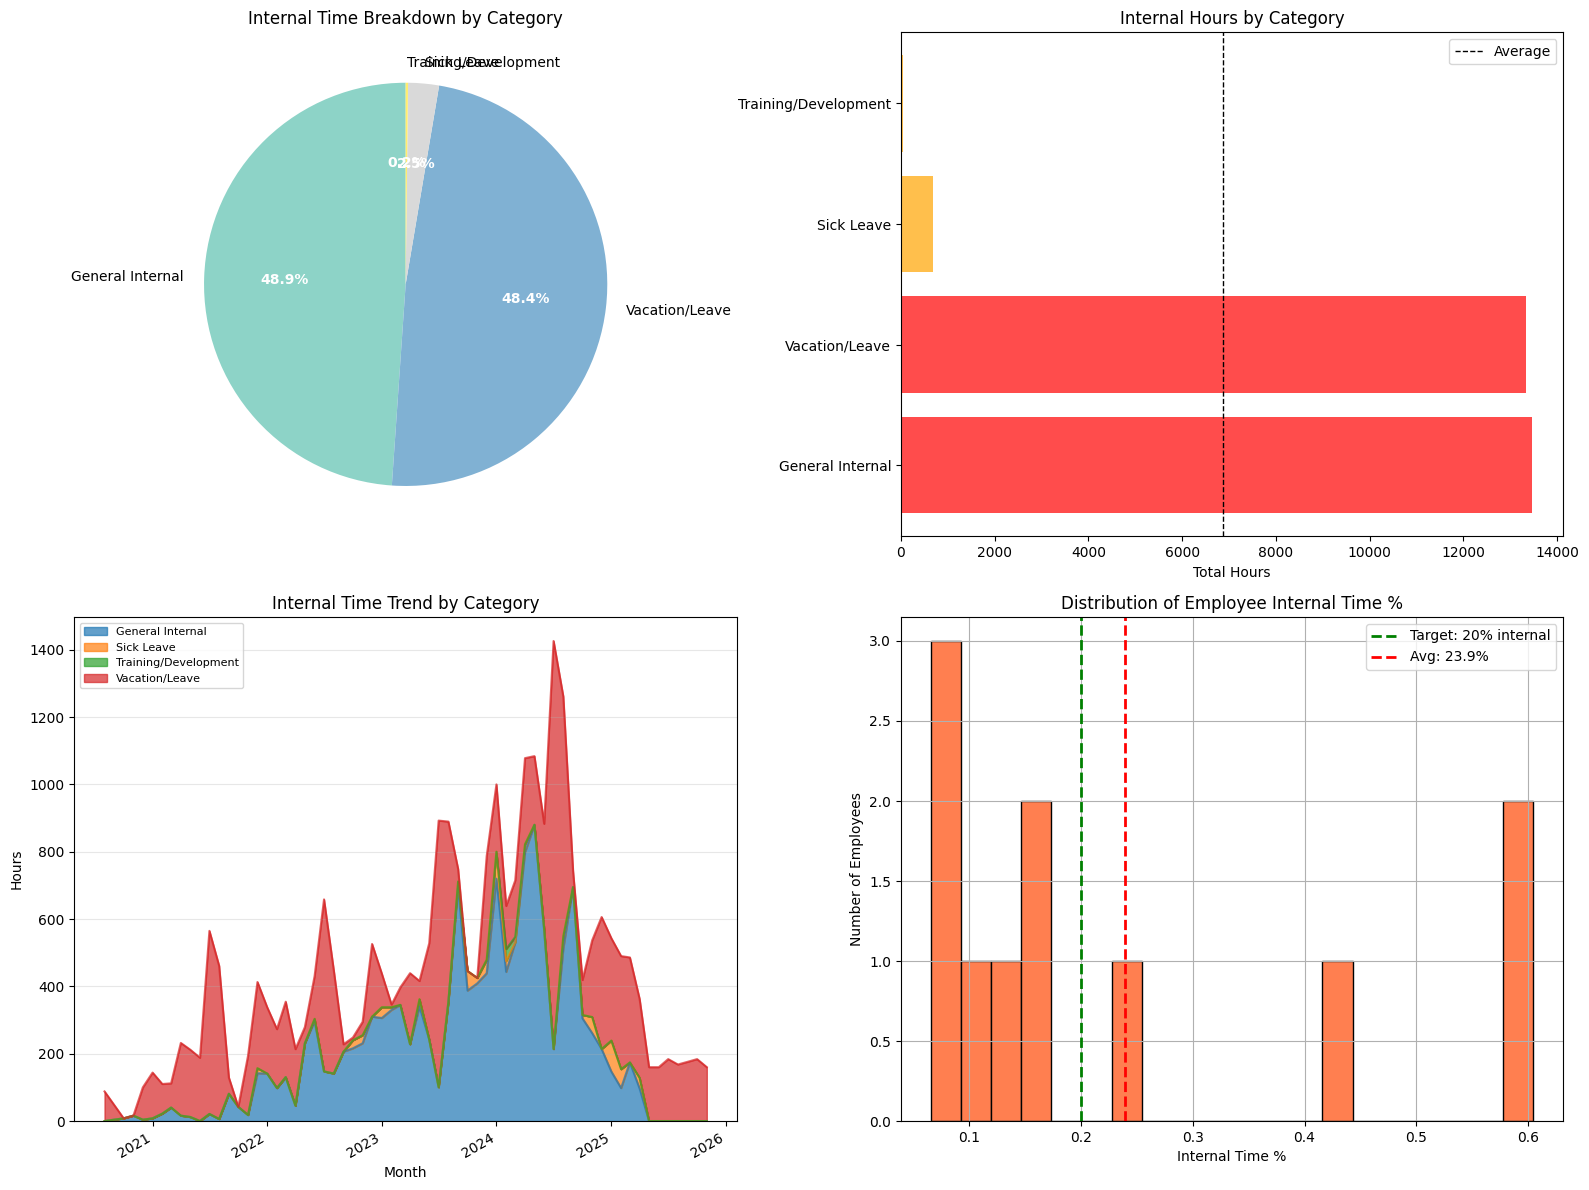

<Figure size 1200x600 with 0 Axes>

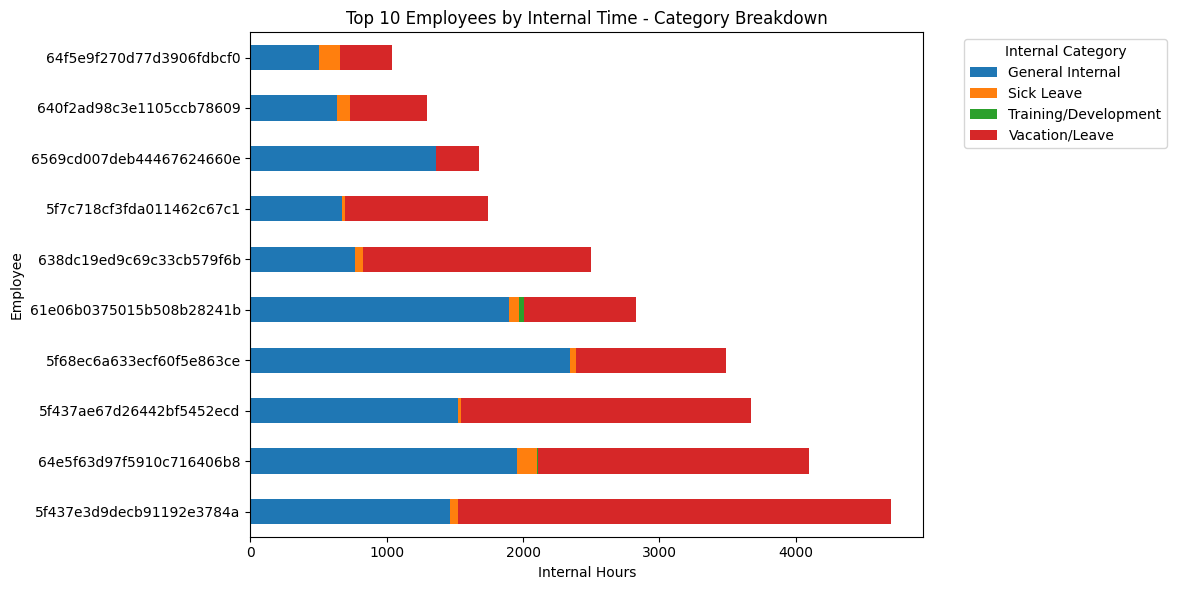

✅ Visualizations complete!


In [ ]:
# ========================================
# CELL 12: Internal Time Visualizations
# ========================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Pie chart - Internal time breakdown
ax1 = axes[0, 0]
colors_internal = plt.cm.Set3(np.linspace(0, 1, len(internal_breakdown_sorted)))
wedges, texts, autotexts = ax1.pie(
    internal_breakdown_sorted['total_hours'],
    labels=internal_breakdown_sorted.index,
    autopct='%1.1f%%',
    colors=colors_internal,
    startangle=90
)
ax1.set_title('Internal Time Breakdown by Category')

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 2. Bar chart - Hours by category
ax2 = axes[0, 1]
categories = internal_breakdown_sorted.index
hours = internal_breakdown_sorted['total_hours']
colors_bar = ['red' if h > internal_breakdown_sorted['total_hours'].mean() else 'orange' 
              for h in hours]

ax2.barh(range(len(categories)), hours, color=colors_bar, alpha=0.7)
ax2.set_yticks(range(len(categories)))
ax2.set_yticklabels(categories)
ax2.set_xlabel('Total Hours')
ax2.set_title('Internal Hours by Category')
ax2.axvline(hours.mean(), color='black', linestyle='--', label='Average', linewidth=1)
ax2.legend()

# 3. Monthly trend (if available)
ax3 = axes[1, 0]
if 'month' in internal_time.columns and len(monthly_internal) > 0:
    monthly_internal[monthly_internal.columns[:-1]].plot(
        kind='area', 
        stacked=True, 
        ax=ax3,
        alpha=0.7
    )
    ax3.set_ylabel('Hours')
    ax3.set_xlabel('Month')
    ax3.set_title('Internal Time Trend by Category')
    ax3.legend(loc='upper left', fontsize=8)
    ax3.grid(axis='y', alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No monthly data available', 
            ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Internal Time Trend (No Data)')

# 4. Employee internal time distribution
ax4 = axes[1, 1]
employee_internal_full['internal_pct'].hist(bins=20, ax=ax4, color='coral', edgecolor='black')
ax4.axvline(0.2, color='green', linestyle='--', linewidth=2, label='Target: 20% internal')
ax4.axvline(employee_internal_full['internal_pct'].mean(), 
           color='red', linestyle='--', linewidth=2, 
           label=f'Avg: {employee_internal_full["internal_pct"].mean():.1%}')
ax4.set_xlabel('Internal Time %')
ax4.set_ylabel('Number of Employees')
ax4.set_title('Distribution of Employee Internal Time %')
ax4.legend()

plt.tight_layout()
plt.show()

# Additional: Stacked bar for top employees showing internal breakdown
top_emp_for_viz = employee_internal_sorted.head(10)
internal_cats = [col for col in employee_internal.columns if col != 'total_internal']

if len(internal_cats) > 0:
    plt.figure(figsize=(12, 6))
    top_emp_for_viz[internal_cats].plot(kind='barh', stacked=True, figsize=(12, 6))
    plt.xlabel('Internal Hours')
    plt.ylabel('Employee')
    plt.title('Top 10 Employees by Internal Time - Category Breakdown')
    plt.legend(title='Internal Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("✅ Visualizations complete!")

In [ ]:
# ========================================
# CELL 13: Utilization Scenario Simulator
# ========================================

print("=" * 60)
print("🎮 UTILIZATION SCENARIO SIMULATOR")
print("=" * 60)

# ============================================
# PART A: BASELINE METRICS
# ============================================

print("\n📊 CURRENT BASELINE")
print("-" * 60)

# Calculate current state
total_hours = fact['hours'].sum()
client_hours = fact['client_facing_hours'].sum()
internal_hours = fact['internal_hours'].sum()
current_utilization = client_hours / total_hours

# Get internal breakdown
internal_by_category = internal_time.groupby('internal_category')['hours'].sum().to_dict()

print(f"\nCurrent State:")
print(f"  Total workforce hours: {total_hours:,.0f}")
print(f"  Client-facing hours: {client_hours:,.0f}")
print(f"  Internal hours: {internal_hours:,.0f}")
print(f"  Current utilization: {current_utilization:.1%}")
print(f"  Target utilization: 80%")
print(f"  Gap to target: {(0.80 - current_utilization):.1%}")

print(f"\nInternal Hours by Category:")
for cat, hours in sorted(internal_by_category.items(), key=lambda x: x[1], reverse=True):
    pct_of_internal = hours / internal_hours
    pct_of_total = hours / total_hours
    print(f"  {cat}: {hours:,.0f}h ({pct_of_internal:.1%} of internal, {pct_of_total:.1%} of total)")

# ============================================
# PART B: SCENARIO MODELING FUNCTION
# ============================================

def simulate_scenario(scenario_name, reductions):
    """
    Simulate utilization impact of reducing internal time categories
    
    Args:
        scenario_name: Name of the scenario
        reductions: dict of {category: reduction_pct} e.g. {'General Internal': 0.30}
    
    Returns:
        dict with scenario results
    """
    # Calculate new internal hours after reductions
    new_internal_by_cat = {}
    hours_saved = 0
    
    for cat, hours in internal_by_category.items():
        reduction_pct = reductions.get(cat, 0)
        hours_reduced = hours * reduction_pct
        new_internal_by_cat[cat] = hours - hours_reduced
        hours_saved += hours_reduced
    
    new_internal_total = sum(new_internal_by_cat.values())
    new_client_hours = client_hours + hours_saved  # Freed hours go to client work
    new_total_hours = total_hours  # Total hours stay the same
    new_utilization = new_client_hours / new_total_hours
    
    # Calculate revenue impact (use average billable rate)
    avg_rate = fact[fact['hourly_rate'].notna()]['hourly_rate'].mean()
    revenue_opportunity = hours_saved * avg_rate
    
    return {
        'scenario_name': scenario_name,
        'hours_saved': hours_saved,
        'new_internal_hours': new_internal_total,
        'new_client_hours': new_client_hours,
        'new_utilization': new_utilization,
        'utilization_gain': new_utilization - current_utilization,
        'revenue_opportunity': revenue_opportunity,
        'reductions': reductions,
        'new_internal_by_cat': new_internal_by_cat
    }

# ============================================
# PART C: PRE-DEFINED SCENARIOS
# ============================================

print("\n" + "=" * 60)
print("📋 SCENARIO ANALYSIS")
print("=" * 60)

# Define scenarios to test
scenarios = []

# Scenario 1: Cut General Internal by 30%
scenarios.append(simulate_scenario(
    "Cut General Internal by 30%",
    {'General Internal': 0.30}
))

# Scenario 2: Cut General Internal 30% + Training 20%
scenarios.append(simulate_scenario(
    "Cut General Internal 30% + Training 20%",
    {'General Internal': 0.30, 'Training/Development': 0.20}
))

# Scenario 3: Aggressive - Cut General Internal 50%, Training 30%, Other 40%
scenarios.append(simulate_scenario(
    "Aggressive Efficiency",
    {'General Internal': 0.50, 'Training/Development': 0.30, 'Other Internal': 0.40}
))

# Scenario 4: Focus on controllable (not vacation/sick)
scenarios.append(simulate_scenario(
    "Optimize Controllable Time",
    {
        'General Internal': 0.40,
        'Training/Development': 0.25,
        'Admin/Meetings': 0.35,
        'Sales/Pre-Sales': 0.20,
        'Other Internal': 0.30
    }
))

# Scenario 5: Moderate across all internal
all_cats_moderate = {cat: 0.20 for cat in internal_by_category.keys() 
                     if cat not in ['Vacation/Leave', 'Sick Leave', 'Parental Leave']}
scenarios.append(simulate_scenario(
    "20% Reduction Across Board",
    all_cats_moderate
))

# Display scenario results
scenarios_df = pd.DataFrame([{
    'Scenario': s['scenario_name'],
    'Hours Saved': s['hours_saved'],
    'New Internal Hours': s['new_internal_hours'],
    'New Utilization': s['new_utilization'],
    'Util Gain': s['utilization_gain'],
    'Revenue Opportunity': s['revenue_opportunity'],
    'Hits 80% Target?': '✅ YES' if s['new_utilization'] >= 0.80 else '❌ NO'
} for s in scenarios])

print("\n🎯 Scenario Comparison:")
display(scenarios_df.style.format({
    'Hours Saved': '{:,.0f}',
    'New Internal Hours': '{:,.0f}',
    'New Utilization': '{:.1%}',
    'Util Gain': '{:+.1%}',
    'Revenue Opportunity': '${:,.0f}'
}))

# ============================================
# PART D: DETAILED SCENARIO BREAKDOWN
# ============================================

print("\n" + "=" * 60)
print("🔍 DETAILED SCENARIO BREAKDOWN")
print("=" * 60)

for scenario in scenarios:
    print(f"\n{'='*60}")
    print(f"📊 {scenario['scenario_name']}")
    print(f"{'='*60}")
    
    print(f"\nReductions Applied:")
    for cat, pct in scenario['reductions'].items():
        if pct > 0:
            old_hours = internal_by_category.get(cat, 0)
            new_hours = scenario['new_internal_by_cat'].get(cat, 0)
            print(f"  {cat}: {old_hours:,.0f}h → {new_hours:,.0f}h (-{pct:.0%})")
    
    print(f"\nResults:")
    print(f"  Hours saved: {scenario['hours_saved']:,.0f}")
    print(f"  Internal hours: {internal_hours:,.0f} → {scenario['new_internal_hours']:,.0f}")
    print(f"  Client-facing hours: {client_hours:,.0f} → {scenario['new_client_hours']:,.0f}")
    print(f"  Utilization: {current_utilization:.1%} → {scenario['new_utilization']:.1%} ({scenario['utilization_gain']:+.1%})")
    print(f"  Revenue opportunity: ${scenario['revenue_opportunity']:,.0f}")
    
    if scenario['new_utilization'] >= 0.80:
        print(f"  ✅ ACHIEVES 80% TARGET!")
    else:
        gap = 0.80 - scenario['new_utilization']
        hours_needed = gap * total_hours
        print(f"  ❌ Still {gap:.1%} short of target")
        print(f"  Need {hours_needed:,.0f} more client-facing hours")

# ============================================
# PART E: CUSTOM SCENARIO BUILDER
# ============================================

print("\n" + "=" * 60)
print("🎨 BUILD YOUR OWN SCENARIO")
print("=" * 60)

print("\nAvailable categories for reduction:")
for i, cat in enumerate(sorted(internal_by_category.keys()), 1):
    print(f"  {i}. {cat}: {internal_by_category[cat]:,.0f}h")

print("\n💡 To create custom scenarios, use:")
print("   my_scenario = simulate_scenario('My Custom Scenario', {")
print("       'General Internal': 0.25,      # 25% reduction")
print("       'Training/Development': 0.15  # 15% reduction")
print("   })")

# Example: Calculate what reduction is needed to hit 80%
print("\n" + "=" * 60)
print("🎯 REQUIRED REDUCTION TO HIT 80% TARGET")
print("=" * 60)

hours_needed_to_move = (0.80 - current_utilization) * total_hours
print(f"\nTo reach 80% utilization:")
print(f"  Need to convert {hours_needed_to_move:,.0f} internal hours to client-facing")
print(f"  This is {hours_needed_to_move/internal_hours:.1%} of current internal time")

print(f"\nExample ways to achieve this:")

# Option 1: Cut largest category proportionally
largest_cat = max(internal_by_category.items(), key=lambda x: x[1])
pct_needed_largest = hours_needed_to_move / largest_cat[1]
if pct_needed_largest <= 1.0:
    print(f"  • Cut '{largest_cat[0]}' by {pct_needed_largest:.1%}")

# Option 2: Spread across multiple categories
controllable_cats = [cat for cat in internal_by_category.keys() 
                     if cat not in ['Vacation/Leave', 'Sick Leave', 'Parental Leave']]
controllable_hours = sum(internal_by_category[cat] for cat in controllable_cats)
uniform_reduction = hours_needed_to_move / controllable_hours if controllable_hours > 0 else 0

if uniform_reduction <= 1.0:
    print(f"  • Reduce all controllable categories by {uniform_reduction:.1%}")
    print(f"    (Excludes: Vacation, Sick Leave, Parental Leave)")

print("\n✅ Scenario simulation complete!")

🎮 UTILIZATION SCENARIO SIMULATOR

📊 CURRENT BASELINE
------------------------------------------------------------

Current State:
  Total workforce hours: 162,207
  Client-facing hours: 134,684
  Internal hours: 27,523
  Current utilization: 83.0%
  Target utilization: 80%
  Gap to target: -3.0%

Internal Hours by Category:
  General Internal: 13,461h (48.9% of internal, 8.3% of total)
  Vacation/Leave: 13,331h (48.4% of internal, 8.2% of total)
  Sick Leave: 679h (2.5% of internal, 0.4% of total)
  Training/Development: 52h (0.2% of internal, 0.0% of total)

📋 SCENARIO ANALYSIS

🎯 Scenario Comparison:


,Scenario,Hours Saved,New Internal Hours,New Utilization,Util Gain,Revenue Opportunity,Hits 80% Target?
0,Cut General Internal by 30%,"4,038","23,485",85.5%,+2.5%,"$5,266,070",✅ YES
1,Cut General Internal 30% + Training 20%,"4,049","23,475",85.5%,+2.5%,"$5,279,632",✅ YES
2,Aggressive Efficiency,"6,746","20,777",87.2%,+4.2%,"$8,797,126",✅ YES
3,Optimize Controllable Time,"5,397","22,126",86.4%,+3.3%,"$7,038,379",✅ YES
4,20% Reduction Across Board,"2,703","24,821",84.7%,+1.7%,"$3,524,275",✅ YES



🔍 DETAILED SCENARIO BREAKDOWN

📊 Cut General Internal by 30%

Reductions Applied:
  General Internal: 13,461h → 9,423h (-30%)

Results:
  Hours saved: 4,038
  Internal hours: 27,523 → 23,485
  Client-facing hours: 134,684 → 138,722
  Utilization: 83.0% → 85.5% (+2.5%)
  Revenue opportunity: $5,266,070
  ✅ ACHIEVES 80% TARGET!

📊 Cut General Internal 30% + Training 20%

Reductions Applied:
  General Internal: 13,461h → 9,423h (-30%)
  Training/Development: 52h → 42h (-20%)

Results:
  Hours saved: 4,049
  Internal hours: 27,523 → 23,475
  Client-facing hours: 134,684 → 138,733
  Utilization: 83.0% → 85.5% (+2.5%)
  Revenue opportunity: $5,279,632
  ✅ ACHIEVES 80% TARGET!

📊 Aggressive Efficiency

Reductions Applied:
  General Internal: 13,461h → 6,731h (-50%)
  Training/Development: 52h → 36h (-30%)
  Other Internal: 0h → 0h (-40%)

Results:
  Hours saved: 6,746
  Internal hours: 27,523 → 20,777
  Client-facing hours: 134,684 → 141,430
  Utilization: 83.0% → 87.2% (+4.2%)
  Revenue opp

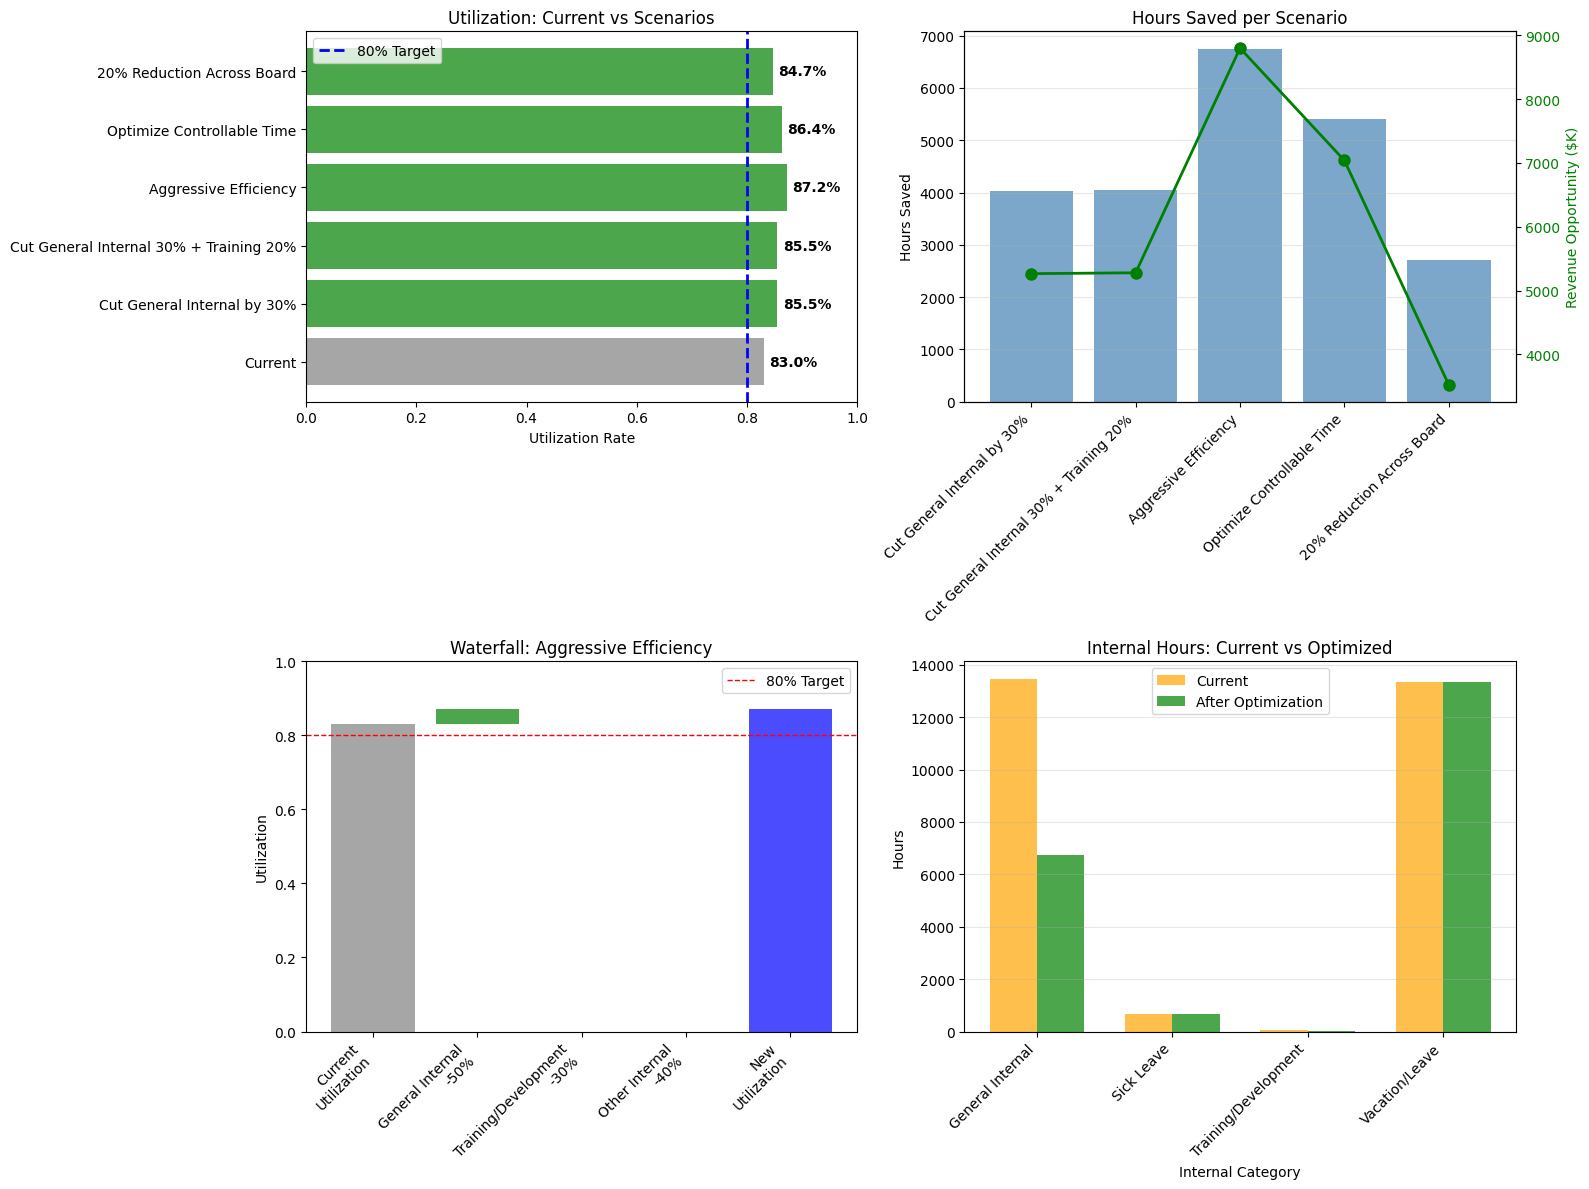


📈 SENSITIVITY ANALYSIS

Utilization Impact of Varying Reduction Levels:


,Category,Current Hours,10%,20%,30%,40%,50%
0,General Internal,"13,461",83.86%,84.69%,85.52%,86.35%,87.18%
1,Vacation/Leave,"13,331",83.85%,84.68%,85.50%,86.32%,87.14%
2,Sick Leave,679,83.07%,83.12%,83.16%,83.20%,83.24%
3,Training/Development,52,83.04%,83.04%,83.04%,83.04%,83.05%



✅ Visualizations complete!


In [ ]:
# ========================================
# CELL 14: Scenario Visualizations
# ========================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Utilization comparison - current vs scenarios
ax1 = axes[0, 0]
scenario_names = ['Current'] + [s['scenario_name'] for s in scenarios]
utilizations = [current_utilization] + [s['new_utilization'] for s in scenarios]
colors = ['gray'] + ['green' if u >= 0.80 else 'orange' for u in utilizations[1:]]

bars = ax1.barh(range(len(scenario_names)), utilizations, color=colors, alpha=0.7)
ax1.set_yticks(range(len(scenario_names)))
ax1.set_yticklabels(scenario_names)
ax1.set_xlabel('Utilization Rate')
ax1.set_title('Utilization: Current vs Scenarios')
ax1.axvline(0.80, color='blue', linestyle='--', linewidth=2, label='80% Target')
ax1.set_xlim(0, 1)
ax1.legend()

# Add value labels
for i, (bar, util) in enumerate(zip(bars, utilizations)):
    ax1.text(util + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{util:.1%}', va='center', fontweight='bold')

# 2. Hours saved comparison
ax2 = axes[0, 1]
hours_saved = [s['hours_saved'] for s in scenarios]
revenue_opps = [s['revenue_opportunity'] for s in scenarios]

x_pos = np.arange(len(scenarios))
ax2.bar(x_pos, hours_saved, alpha=0.7, color='steelblue')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([s['scenario_name'] for s in scenarios], rotation=45, ha='right')
ax2.set_ylabel('Hours Saved')
ax2.set_title('Hours Saved per Scenario')
ax2.grid(axis='y', alpha=0.3)

# Add revenue on secondary axis
ax2_twin = ax2.twinx()
ax2_twin.plot(x_pos, [r/1000 for r in revenue_opps], 
             color='green', marker='o', linewidth=2, markersize=8)
ax2_twin.set_ylabel('Revenue Opportunity ($K)', color='green')
ax2_twin.tick_params(axis='y', labelcolor='green')

# 3. Waterfall chart - best scenario breakdown
ax3 = axes[1, 0]
best_scenario = max(scenarios, key=lambda x: x['new_utilization'])

# Build waterfall
categories = ['Current\nUtilization']
values = [current_utilization]
colors_waterfall = ['gray']

for cat, pct in best_scenario['reductions'].items():
    if pct > 0:
        old_hours = internal_by_category.get(cat, 0)
        hours_reduced = old_hours * pct
        util_gain = hours_reduced / total_hours
        categories.append(f"{cat}\n-{pct:.0%}")
        values.append(util_gain)
        colors_waterfall.append('green')

categories.append('New\nUtilization')
values.append(best_scenario['new_utilization'])
colors_waterfall.append('blue')

# Create waterfall
cumulative = [current_utilization]
for i in range(1, len(values) - 1):
    cumulative.append(cumulative[-1] + values[i])
cumulative.append(values[-1])

ax3.bar(range(len(categories)), 
       [values[0]] + values[1:-1] + [values[-1]], 
       bottom=[0] + cumulative[:-2] + [0],
       color=colors_waterfall, alpha=0.7)

ax3.set_xticks(range(len(categories)))
ax3.set_xticklabels(categories, rotation=45, ha='right')
ax3.set_ylabel('Utilization')
ax3.set_title(f'Waterfall: {best_scenario["scenario_name"]}')
ax3.axhline(0.80, color='red', linestyle='--', linewidth=1, label='80% Target')
ax3.set_ylim(0, 1)
ax3.legend()

# 4. Internal hours composition - current vs best scenario
ax4 = axes[1, 1]

# Current state
current_cats = list(internal_by_category.keys())
current_vals = [internal_by_category[cat] for cat in current_cats]

# Best scenario state
best_vals = [best_scenario['new_internal_by_cat'].get(cat, 0) for cat in current_cats]

x = np.arange(len(current_cats))
width = 0.35

bars1 = ax4.bar(x - width/2, current_vals, width, label='Current', alpha=0.7, color='orange')
bars2 = ax4.bar(x + width/2, best_vals, width, label='After Optimization', alpha=0.7, color='green')

ax4.set_xlabel('Internal Category')
ax4.set_ylabel('Hours')
ax4.set_title('Internal Hours: Current vs Optimized')
ax4.set_xticks(x)
ax4.set_xticklabels(current_cats, rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Additional: Sensitivity analysis
print("\n" + "=" * 60)
print("📈 SENSITIVITY ANALYSIS")
print("=" * 60)

# Show what happens with different reduction levels for each category
print("\nUtilization Impact of Varying Reduction Levels:")

sensitivity_data = []
for cat in sorted(internal_by_category.keys(), key=lambda x: internal_by_category[x], reverse=True)[:5]:
    row = {'Category': cat, 'Current Hours': internal_by_category[cat]}
    for reduction_pct in [0.10, 0.20, 0.30, 0.40, 0.50]:
        scenario = simulate_scenario(f"Test {cat}", {cat: reduction_pct})
        row[f'{reduction_pct:.0%}'] = scenario['new_utilization']
    sensitivity_data.append(row)

sensitivity_df = pd.DataFrame(sensitivity_data)
display(sensitivity_df.style.format({
    'Current Hours': '{:,.0f}',
    '10%': '{:.2%}',
    '20%': '{:.2%}',
    '30%': '{:.2%}',
    '40%': '{:.2%}',
    '50%': '{:.2%}'
}))

print("\n✅ Visualizations complete!")